# Automated Voigt Species Plots (VSP): CIV

This code is able to take the component groups and turn it into a csv file that contains all the information about the Veeper fits. It then reduces the pandas data frame to just the fits of the galaxy and runs them through a function that returns the voigt fit and the velocities associated with them to make voigt species plots similar to those seen in Figure 3 of Werk et al. 2013 (https://iopscience.iop.org/article/10.1088/0067-0049/204/2/17/pdf)

Note: This code is meant to be run after the veeper_create-run-collate.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 14

# update various fontsizes to match
params = {'figure.figsize': (18, 12),
          'legend.fontsize': 11,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

import glob
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList

#### Information for each Galaxy/QSO LOS: 
- ##### NGC 3489 / J1101: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/SamIDs_jess_Nov29_2022.json' 
    - norm = 'J1101+1429_nbin3_jwnorm.fits'
    - Galaxy z: 0.002258
    - QSO z: 0.635
    - V (Helio) [km/s]: 676.9

- ##### NGC 4026 / J1159: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/SamIDs_meth3_Nov28_2022.json'
    - norm = 'J1159+5106_nbin3_jwnorm_meth3.fits'
    - Galaxy z: 0.003286
    - QSO z: 0.524
    - V (Helio) [km/s]: 985.1
    
- ##### NGC 4736 / J1249: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/SamIDs_Nov28_2022.json'
    - norm = 'J1249+4122_nbin3_visit12_jwnorm.fits'
    - Galaxy z: 0.001027
    - QSO z: 0.368
    - V (Helio) [km/s]: 307.8
    
- ##### NGC 3414 / 1051: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/SamIDs_Nov29_2022.json'
    - norm = 'J1051+2805_nbin3_jwnorm.fits'
    - Galaxy z: 0.0049
    - QSO z: 0.423
    - V (Helio) [km/s]: 1469.8
    - all_vp_df.loc[(all_vp_df['zsys'] > 0.002) &  (all_vp_df['zsys'] < 0.005) ]
    - specfile = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits'
    
- ##### NGC 3627 / J1123: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123+1257/SamIDs_Nov29_2022.json'
    - norm = 'J1123+1257_nbin3_BASIC_jwnorm.fits'
    - Galaxy z: 0.00243
    - QSO z: 0.315
    - V (Helio) [km/s]: 721

- ##### NGC 1097 / J0246: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246-3007/SamIDs_Nov28_2022.json'
    - norm = 'J0246-3007_nbin3_allvisits_jwnorm.fits'
    - Galaxy z: 0.00424
    - QSO z: 0.524
    - V (Helio) [km/s]: 1271.1

- ##### NGC 4564 / J1235: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235+1123/SamIDs_Nov28_2022.json'
    - norm = 'J1235+1123_twovisits_m3_jwnorm.fits'
    - Galaxy z: 0.003809
    - QSO z: 0.949
    - V (Helio) [km/s]: 1141.9

In [45]:
all_vp_df_J1101 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1101/all_vp.csv')
all_vp_df_J1159 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1159/all_vp.csv')
all_vp_df_J1249 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1249/all_vp.csv')
all_vp_df_J1051 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1051/all_vp.csv')
all_vp_df_J1123 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1123/all_vp.csv')
all_vp_df_J0246 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J0246/all_vp.csv')
all_vp_df_J1235 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1235/all_vp.csv')

In [3]:
#We care about the absorption features that we see around the galaxy so need to input the correct info for each one 
#Used some galaxy criterion to only see the lines that fit what I want to plot 

gal_df_J1101 = all_vp_df_J1101.loc[(all_vp_df_J1101['trans']=='C IV')] #[(all_vp_df_J1101['zsys'] > 0.0) & (all_vp_df_J1101['zsys'] < 0.003) ]
gal_df_J1101 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
16,16,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1548.204,0.00004,13.954,0.029,44.1,3.845,-1.221,2.681,...,-60.8394,60.8394,1547.946350,1548.574730,4468,4486,0.00003,C IV,a,--
17,17,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1550.781,0.00004,13.954,0.000,44.1,0.000,-1.221,0.000,...,-60.8394,60.8394,1550.522922,1551.152348,4539,4556,0.00003,C IV,a,--
18,18,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1548.204,0.00047,13.482,0.068,20.0,5.285,-1.909,3.358,...,-40.5596,40.5596,1548.718743,1549.137663,4489,4501,0.00046,C IV,b,--
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1550.781,0.00047,13.482,0.000,20.0,0.000,-1.909,0.000,...,-40.5596,40.5596,1551.296600,1551.716217,4560,4571,0.00046,C IV,b,--
20,20,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1548.204,0.00223,13.403,0.099,35.7,11.549,2.357,7.816,...,-50.6995,50.6995,1551.389731,1551.913381,4562,4577,0.00223,C IV,b,--
21,21,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1550.781,0.00223,13.403,0.000,35.7,0.000,2.357,0.000,...,-50.6995,50.6995,1553.972034,1554.496555,4633,4647,0.00223,C IV,b,--


In [46]:
gal_df_J1159 = all_vp_df_J1159.loc[(all_vp_df_J1159['trans']=='C IV')] # (all_vp_df_J1159['zsys'] > 0.002) & (all_vp_df_J1159['zsys'] < 0.005) & 
gal_df_J1159

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
4,4,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,...,-155.9011,155.9011,1552.505592,1554.115817,4620,4664,0.00327,C IV,b,--
5,5,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1550.781,0.00330,13.697,0.000,80.715,0.000,-9.444,0.000,...,-155.9011,155.9011,1555.089752,1556.702657,4690,4734,0.00327,C IV,b,--
37,37,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1548.204,-0.00012,14.166,0.022,58.259,3.748,-12.256,2.552,...,-101.3991,101.3991,1547.501253,1548.548554,4484,4512,-0.00016,C IV,b,--
38,38,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1550.781,-0.00012,14.166,0.000,58.259,0.000,-12.256,0.000,...,-101.3991,101.3991,1550.077083,1551.126128,4554,4582,-0.00016,C IV,b,--


In [63]:
gal_df_J1249 = all_vp_df_J1249.loc[(all_vp_df_J1249['trans']=='C IV')]#(all_vp_df_J1249['zsys'] > -0.0007) & (all_vp_df_J1249['zsys'] < 0.002) ]
gal_df_J1249

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
12,12,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.204,-0.00016,13.930,0.053,39.514,6.602,7.602,4.552,...,-88.7242,88.7242,1547.501252,1548.417640,4484,4509,-0.00013,C IV,b,--
13,13,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.781,-0.00016,13.930,0.000,39.514,0.000,7.602,0.000,...,-88.7242,88.7242,1550.077082,1550.994995,4554,4579,-0.00013,C IV,b,--
14,14,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.204,0.00052,13.681,0.091,15.374,6.144,9.767,3.623,...,-22.8148,22.8148,1548.888922,1549.124565,4521,4528,0.00055,C IV,c,--
15,15,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.781,0.00052,13.681,0.000,15.374,0.000,9.767,0.000,...,-22.8148,22.8148,1551.467062,1551.703097,4592,4598,0.00055,C IV,c,--
16,16,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.204,0.00071,13.468,0.141,25.500,14.417,15.126,7.972,...,-78.5843,78.5843,1548.902025,1549.713683,4522,4544,0.00076,C IV,c,--
17,17,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.781,0.00071,13.468,0.000,25.500,0.000,15.126,0.000,...,-78.5843,78.5843,1551.480187,1552.293196,4592,4614,0.00076,C IV,c,--
18,18,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.204,0.00106,13.609,0.102,34.454,11.889,12.287,7.831,...,-24.0823,24.0823,1549.719692,1549.968426,4544,4551,0.00110,C IV,c,--
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.781,0.00106,13.609,0.000,34.454,0.000,12.287,0.000,...,-24.0823,24.0823,1552.299215,1552.548363,4614,4621,0.00110,C IV,c,--


In [6]:
gal_df_J1051 = all_vp_df_J1051.loc[(all_vp_df_J1051['trans']=='C IV')] # [(all_vp_df_J1051['zsys'] > 0.002) & (all_vp_df_J1051['zsys'] < 0.005) ]
gal_df_J1051 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
12,12,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1548.204,-0.00042,13.985,0.060,34.264,6.485,27.736,4.551,...,-54.8087,54.8087,1547.277753,1547.843845,4477,4493,-0.00032,C IV,b,--
13,13,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1550.781,-0.00042,13.985,0.000,34.264,0.000,27.736,0.000,...,-54.8087,54.8087,1549.853211,1550.420245,4548,4563,-0.00032,C IV,b,--
14,14,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1548.204,-0.00003,14.012,0.064,39.000,8.952,6.465,4.749,...,-38.4827,38.4827,1547.964285,1548.361753,4496,4507,-0.00000,C IV,b,--
15,15,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1550.781,-0.00003,14.012,0.000,39.000,0.000,6.465,0.000,...,-38.4827,38.4827,1550.540886,1550.939016,4566,4577,-0.00000,C IV,b,--
16,16,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1548.204,0.00026,13.388,0.153,27.700,14.962,16.652,9.372,...,-39.6488,39.6488,1548.397891,1548.807403,4508,4519,0.00031,C IV,c,--
17,17,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1550.781,0.00026,13.388,0.000,27.700,0.000,16.652,0.000,...,-39.6488,39.6488,1550.975213,1551.385408,4578,4589,0.00031,C IV,c,--
18,18,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,...,-74.6331,74.6331,1554.656745,1555.427594,4679,4700,0.00444,C IV,a,--
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1550.781,0.00442,13.990,0.000,32.780,0.000,6.646,0.000,...,-74.6331,74.6331,1557.244486,1558.016617,4749,4770,0.00444,C IV,a,--


In [7]:
gal_df_J1123 = all_vp_df_J1123.loc[(all_vp_df_J1123['zsys'] > 0.002) &  (all_vp_df_J1123['zsys'] < 0.003) ]
gal_df_J1123

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
4,4,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1526.707,0.00248,13.472,0.251,26.7,24.449,-24.959,15.925,...,-44.8278,44.8278,1530.263999,1530.720574,4014,4026,0.00240,SiII,b,--
9,9,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1548.204,0.00255,13.650,0.610,5.3,5.278,-4.231,3.866,...,-35.1967,35.1967,1551.976441,1552.339971,4606,4615,0.00254,C IV,b,--
10,10,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1550.781,0.00255,13.650,0.000,5.3,0.000,-4.231,0.000,...,-35.1967,35.1967,1554.559721,1554.923855,4676,4686,0.00254,C IV,b,--
11,11,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1548.204,0.00286,13.791,0.132,52.3,23.021,-27.086,13.681,...,-50.5953,50.5953,1552.375206,1552.897779,4616,4631,0.00277,C IV,b,--
12,12,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123...,1550.781,0.00286,13.791,0.000,52.3,0.000,-27.086,0.000,...,-50.5953,50.5953,1554.959149,1555.482592,4687,4701,0.00277,C IV,b,--


In [8]:
gal_df_J0246 = all_vp_df_J0246.loc[(all_vp_df_J0246['zsys'] > 0.003) &  (all_vp_df_J0246['zsys'] < 0.005) 
                                  & (all_vp_df_J0246['trans']=='C IV')]
gal_df_J0246

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
6,6,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1548.204,0.00422,14.211,0.053,54.1,7.973,18.21,5.687,...,-71.0328,71.0328,1554.365666,1555.099329,4671,4691,0.00428,C IV,a,--
7,7,/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246...,1550.781,0.00422,14.211,0.000,54.1,0.000,18.21,0.000,...,-71.0328,71.0328,1556.952922,1557.687806,4741,4761,0.00428,C IV,a,--


In [9]:
gal_df_J1235 = all_vp_df_J1235.loc[(all_vp_df_J1235['zsys'] > -0.1) &  (all_vp_df_J1235['zsys'] < 0.004) & (all_vp_df_J1235['trans']=='C IV')]
gal_df_J1235

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
0,0,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235...,1548.204,-0.00001,14.218,0.029,48.143,3.92,18.541,2.873,...,-74.0945,74.0945,1547.800549,1548.565835,4492,4513,0.00005,C IV,a,--
1,1,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235...,1550.781,-0.00001,14.218,0.000,48.143,0.00,18.541,0.000,...,-74.0945,74.0945,1550.376878,1551.143437,4562,4583,0.00005,C IV,a,--


In [64]:
#Pull the parts from gal_df that I want/need for the fitting and plots 

#J1101 Values 
trans_J1101 = np.array(gal_df_J1101['trans'])
zsys_J1101 = np.array(gal_df_J1101['zsys'])
N_J1101 = np.array(gal_df_J1101['col'])
b_J1101 = np.array(gal_df_J1101['bval'])
vel_J1101 = np.array(gal_df_J1101['vel'])
wav_J1101 = np.array(gal_df_J1101['restwave'])

#J1159 Values 
trans_J1159 = np.array(gal_df_J1159['trans'])
zsys_J1159 = np.array(gal_df_J1159['zsys'])
N_J1159 = np.array(gal_df_J1159['col'])
b_J1159 = np.array(gal_df_J1159['bval'])
vel_J1159 = np.array(gal_df_J1159['vel'])
wav_J1159 = np.array(gal_df_J1159['restwave'])

#J1249 Values 
trans_J1249 = np.array(gal_df_J1249['trans'])
zsys_J1249 = np.array(gal_df_J1249['zsys'])
N_J1249 = np.array(gal_df_J1249['col'])
b_J1249 = np.array(gal_df_J1249['bval'])
vel_J1249 = np.array(gal_df_J1249['vel'])
wav_J1249 = np.array(gal_df_J1249['restwave'])

#J1051 Values 
trans_J1051 = np.array(gal_df_J1051['trans'])
zsys_J1051 = np.array(gal_df_J1051['zsys'])
N_J1051 = np.array(gal_df_J1051['col'])
b_J1051 = np.array(gal_df_J1051['bval'])
vel_J1051 = np.array(gal_df_J1051['vel'])
wav_J1051 = np.array(gal_df_J1051['restwave'])

#J1123 Values 
trans_J1123 = np.array(gal_df_J1123['trans'])
zsys_J1123 = np.array(gal_df_J1123['zsys'])
N_J1123 = np.array(gal_df_J1123['col'])
b_J1123 = np.array(gal_df_J1123['bval'])
vel_J1123 = np.array(gal_df_J1123['vel'])
wav_J1123 = np.array(gal_df_J1123['restwave'])

#J0246 Values 
trans_J0246= np.array(gal_df_J0246['trans'])
zsys_J0246 = np.array(gal_df_J0246['zsys'])
N_J0246 = np.array(gal_df_J0246['col'])
b_J0246 = np.array(gal_df_J0246['bval'])
vel_J0246 = np.array(gal_df_J0246['vel'])
wav_J0246 = np.array(gal_df_J0246['restwave'])

#J1235 Values 
trans_J1235= np.array(gal_df_J1235['trans'])
zsys_J1235 = np.array(gal_df_J1235['zsys'])
N_J1235 = np.array(gal_df_J1235['col'])
b_J1235 = np.array(gal_df_J1235['bval'])
vel_J1235 = np.array(gal_df_J1235['vel'])
wav_J1235 = np.array(gal_df_J1235['restwave'])

In [65]:
# Define constants

from astropy import constants as const
c = const.c.to('km/s').value #speed of light in km/s for velocity => redshift conversions 

# Load spectrum for plotting
ism = LineList('ISM')

#J1101
specfile_J1101 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/J1101+1429_nbin3_jwnorm.fits' #normalized spectra file 
xspec_J1101 = lsio.readspec(specfile_J1101)

#J1159
specfile_J1159 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/J1159+5106_nbin3_jwnorm_meth3.fits' #normalized spectra file 
xspec_J1159 = lsio.readspec(specfile_J1159)

#J1249
specfile_J1249 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/J1249+4122_nbin3_visit12_jwnorm.fits' #normalized spectra file 
xspec_J1249 = lsio.readspec(specfile_J1249)

#J1051
specfile_J1051 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits' #normalized spectra file 
xspec_J1051 = lsio.readspec(specfile_J1051)

#J1123
specfile_J1123 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123+1257/J1123+1257_nbin3_BASIC_jwnorm.fits' #normalized spectra file 
xspec_J1123 = lsio.readspec(specfile_J1123)

#J0246
specfile_J0246 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246-3007/J0246-3007_nbin3_allvisits_jwnorm.fits' #normalized spectra file 
xspec_J0246 = lsio.readspec(specfile_J0246)

#J1235
specfile_J1235 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235+1123/J1235+1123_twovisits_m3_jwnorm.fits' #normalized spectra file 
xspec_J1235 = lsio.readspec(specfile_J1235)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [12]:
#Converts wavelengths to velocities 
def convert_wave2vel(obs_wave, rest_wave, LSR_vel=0.):
    # Define constants
    c = const.c.to('km/s').value #has the right value but no units 
    return (((obs_wave - rest_wave)/rest_wave) * c) - LSR_vel #calculates z then * c to makes velocity

#Function to make the bulk of the species plots 
def voigt_species(xspec, redshift, column_density, b_value, restwavelen, LSR): 
    # Set line attributes 
    N = 10**(column_density)/u.km**2  # Column density => Not sure on the units of this 
    b = b_value*u.km/u.s      # Doppler b parameter => Not sure on the units of this => 
    z = redshift            # redshift of absorption feature
    restwav = restwavelen*u.Angstrom

    absline = AbsLine(restwav)  # Initialize AbsLine object
    absline.attrib['N'] = N
    absline.attrib['b'] = b
    absline.setz(z)
    
    # Generate model voigt profiles

    wv_array = xspec.wavelength # Use wavelength array from the spectrum you loaded

    voigt = absline.generate_voigt(wave=wv_array)
    
    vels = convert_wave2vel(wv_array, restwav, LSR_vel=LSR) #This LSR_vel changes for each galaxy/QSO LOS 
    
    return voigt, vels

In [66]:
#This is the actually automated part and this makes life so much easier 

LSR_values = np.array([676.9, 985.1, 307.8, 1469.8, 721, 1271.1, 1141.9])

#J1101
Voigt_J1101 = []
Vels_J1101 = []

for i in range(len(trans_J1101)): 
    vo, ve = voigt_species(xspec_J1101, zsys_J1101[i], N_J1101[i], b_J1101[i], wav_J1101[i], LSR_values[0])
    Voigt_J1101.append(vo)
    Vels_J1101.append(ve)
    
#J1159
Voigt_J1159 = []
Vels_J1159 = []

for i in range(len(trans_J1159)): 
    vo, ve = voigt_species(xspec_J1159, zsys_J1159[i], N_J1159[i], b_J1159[i], wav_J1159[i], LSR_values[1])
    Voigt_J1159.append(vo)
    Vels_J1159.append(ve)
    
#J1249
Voigt_J1249 = []
Vels_J1249 = []

for i in range(len(trans_J1249)): 
    vo, ve = voigt_species(xspec_J1249, zsys_J1249[i], N_J1249[i], b_J1249[i], wav_J1249[i], LSR_values[2])
    Voigt_J1249.append(vo)
    Vels_J1249.append(ve)

#J051
Voigt_J1051 = []
Vels_J1051 = []

for i in range(len(trans_J1051)): 
    vo, ve = voigt_species(xspec_J1051, zsys_J1051[i], N_J1051[i], b_J1051[i], wav_J1051[i], LSR_values[3])
    Voigt_J1051.append(vo)
    Vels_J1051.append(ve)
    
#J1123
Voigt_J1123 = []
Vels_J1123 = []

for i in range(len(trans_J1123)): 
    vo, ve = voigt_species(xspec_J1123, zsys_J1123[i], N_J1123[i], b_J1123[i], wav_J1123[i], LSR_values[4])
    Voigt_J1123.append(vo)
    Vels_J1123.append(ve)
    
#J0246
Voigt_J0246 = []
Vels_J0246 = []

for i in range(len(trans_J0246)): 
    vo, ve = voigt_species(xspec_J0246, zsys_J0246[i], N_J0246[i], b_J0246[i], wav_J0246[i], LSR_values[5])
    Voigt_J0246.append(vo)
    Vels_J0246.append(ve)
    
#J1235
Voigt_J1235 = []
Vels_J1235 = []

for i in range(len(trans_J1235)): 
    vo, ve = voigt_species(xspec_J1235, zsys_J1235[i], N_J1235[i], b_J1235[i], wav_J1235[i], LSR_values[6])
    Voigt_J1235.append(vo)
    Vels_J1235.append(ve)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/samgarza/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:244: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:245: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on 

In [67]:
#labels for each feature

#J1101
labels_J1101 = []
for i in range(len(trans_J1101)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1101.append((trans_J1101[i], wav_J1101[i], zsys_J1101[i], N_J1101[i], b_J1101[i]))

#J1159
labels_J1159 = []
for i in range(len(trans_J1159)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1159.append((trans_J1159[i], wav_J1159[i], zsys_J1159[i], N_J1159[i], b_J1159[i]))

#J1249
labels_J1249 = []
for i in range(len(trans_J1249)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1249.append((trans_J1249[i], wav_J1249[i], zsys_J1249[i], N_J1249[i], b_J1249[i]))

#J1051
labels_J1051 = []
for i in range(len(trans_J1051)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1051.append((trans_J1051[i], wav_J1051[i], zsys_J1051[i], N_J1051[i], b_J1051[i]))

#J1123
labels_J1123 = []
for i in range(len(trans_J1123)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1123.append((trans_J1123[i], wav_J1123[i], zsys_J1123[i], N_J1123[i], b_J1123[i]))
    
#J0246
labels_J0246 = []
for i in range(len(trans_J0246)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J0246.append((trans_J0246[i], wav_J0246[i], zsys_J0246[i], N_J0246[i], b_J0246[i]))
    
#J1235
labels_J1235 = []
for i in range(len(trans_J1235)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1235.append((trans_J1235[i], wav_J1235[i], zsys_J1235[i], N_J1235[i], b_J1235[i]))
labels_J1249

[('C IV', 1548.204, -0.00016, 13.93, 39.514),
 ('C IV', 1550.781, -0.00016, 13.93, 39.514),
 ('C IV', 1548.204, 0.00052, 13.681, 15.374),
 ('C IV', 1550.781, 0.00052, 13.681, 15.374),
 ('C IV', 1548.204, 0.00071, 13.468, 25.5),
 ('C IV', 1550.781, 0.00071, 13.468, 25.5),
 ('C IV', 1548.204, 0.00106, 13.609, 34.454),
 ('C IV', 1550.781, 0.00106, 13.609, 34.454)]

In [82]:
#VSP for each galaxy 

#J1101
def J1101_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 3489 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0, 2, 4)
    axs[0].step(Vels_J1101[0], xspec_J1101.flux/xspec_J1101.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-800, -450, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels_J1101[0]+vel_J1101[0], Voigt_J1101[0].flux, c='silver', lw=3)  
    axs[0].plot(Vels_J1101[2]+vel_J1101[2], Voigt_J1101[2].flux, c='silver', lw=3) 
    axs[0].plot(Vels_J1101[4]+vel_J1101[4], Voigt_J1101[4].flux, c='deepskyblue', lw=3, label = labels_J1101[4] )
    axs[0].plot(Vels_J1101[0], xspec_J1101.sig/xspec_J1101.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-900,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.002258, b = 110.0, log$M_{*}$=10.2$M_{\odot}$, log$M_{BH}$ = 6.77$M_{\odot}$; QSO: J1101+1429, z = 0.6359', fontsize=15)
    axs[0].legend(loc=4)

    #CIV 1550 (1, 3, and 5)
    axs[1].step(Vels_J1101[1], xspec_J1101.flux/xspec_J1101.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-800, -450, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels_J1101[1]+vel_J1101[1], Voigt_J1101[1].flux, c='silver', lw=3) 
    axs[1].plot(Vels_J1101[3]+vel_J1101[3], Voigt_J1101[3].flux, c='silver', lw=3) 
    axs[1].plot(Vels_J1101[5]+vel_J1101[5], Voigt_J1101[5].flux, c='deepskyblue', lw=3, label = labels_J1101[5] )
    axs[1].plot(Vels_J1101[1], xspec_J1101.sig/xspec_J1101.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-900,200)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J1159
def J1159_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 4026 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0, 2, 4, 6)
    axs[0].step(Vels_J1159[0], xspec_J1159.flux/xspec_J1159.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-1200, -900, alpha = 0.35, color = 'lightgrey') 
    axs[0].plot(Vels_J1159[2]+vel_J1159[2], Voigt_J1159[2].flux, c='silver', lw=3) 
    axs[0].plot(Vels_J1159[0]+vel_J1159[0], Voigt_J1159[0].flux, c='violet', lw=3, label = labels_J1159[0] ) 
    axs[0].plot(Vels_J1159[0], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1400,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.003286, b = 37.38, log$M_{*}$$M_{\odot}$ = 10.43, log$M_{BH}$ = 8.25$M_{\odot}$; QSO: J1159+5106, z = 0.524',fontsize=15)
    axs[0].legend(loc=4)

    #CIV 1550 (1, 3, 5, and 7 )
    axs[1].step(Vels_J1159[1], xspec_J1159.flux/xspec_J1159.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-1200, -900, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels_J1159[3]+vel_J1159[3], Voigt_J1159[3].flux, c='silver', lw=3) 
    axs[1].plot(Vels_J1159[1]+vel_J1159[1], Voigt_J1159[1].flux, c='violet', lw=3, label = labels_J1159[1] ) 
    axs[1].plot(Vels_J1159[1], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1400,200)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')

    '''#SiIV 1392 (8 and 10)
    axs[0,1].step(Vels_J1159[8], xspec_J1159.flux/xspec_J1159.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels_J1159[8]+vel_J1159[8], Voigt_J1159[8].flux, c='blue', lw=3, label = labels_J1159[8]) 
    axs[0,1].plot(Vels_J1159[10]+vel_J1159[10], Voigt_J1159[10].flux, c='blueviolet', lw=3, label = labels_J1159[10])
    axs[0,1].plot(Vels_J1159[8], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    axs[0,1].set_xlim(-300,300)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1159+5106, z = 0.524', fontsize=15)
    axs[0,1].legend(loc=4)

    #SiIV 1402 (9 and 11)
    axs[1,1].step(Vels_J1159[9], xspec_J1159.flux/xspec_J1159.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels_J1159[9]+vel_J1159[9], Voigt_J1159[9].flux, c='blue', lw=3, label = labels_J1159[9] ) 
    axs[1,1].plot(Vels_J1159[11]+vel_J1159[11], Voigt_J1159[11].flux, c='blueviolet', lw=3, label = labels_J1159[11] )
    axs[1,1].plot(Vels_J1159[9], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    axs[1,1].set_xlim(-300,300)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].set_xlabel('Relative Velocity [km/s]')
    axs[1,1].legend(loc=4)'''

#################################################################

#J1249
def J1249_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 4736 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0 ,2, 4, 6)
    axs[0].step(Vels_J1249[0], xspec_J1249.flux/xspec_J1249.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-450, -250, alpha = 0.35, color = 'lightgrey')
    axs[0].axvspan(-200, -32, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels_J1249[0]+vel_J1249[0], Voigt_J1249[0].flux, c='silver', lw=3)  
    axs[0].plot(Vels_J1249[2]+vel_J1249[2], Voigt_J1249[2].flux, c='silver', lw=3)  
    axs[0].plot(Vels_J1249[4]+vel_J1249[4], Voigt_J1249[4].flux, c='silver', lw=3)  
    axs[0].plot(Vels_J1249[6]+vel_J1249[6], Voigt_J1249[6].flux, c='deepskyblue', lw=3, label = labels_J1249[6] )  
    axs[0].plot(Vels_J1249[0], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-700,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.001027, b = 25.52, log$M_{*}$$M_{\odot}$ = 10.62, log$M_{BH}$ = 6.83$M_{\odot}$; QSO: J1249+4122, z = 0.3682',fontsize=15)
    axs[0].legend(loc=4)

    #CIV 1550 (1, 3, 5, 7)
    axs[1].step(Vels_J1249[1], xspec_J1249.flux/xspec_J1249.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-450, -250, alpha = 0.35, color = 'lightgrey')
    axs[1].axvspan(-200, -32, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels_J1249[1]+vel_J1249[1], Voigt_J1249[1].flux, c='silver', lw=3) 
    axs[1].plot(Vels_J1249[3]+vel_J1249[3], Voigt_J1249[3].flux, c='silver', lw=3) 
    axs[1].plot(Vels_J1249[5]+vel_J1249[5], Voigt_J1249[5].flux, c='silver', lw=3) 
    axs[1].plot(Vels_J1249[7]+vel_J1249[7], Voigt_J1249[7].flux, c='deepskyblue', lw=3, label = labels_J1249[7]) 
    axs[1].plot(Vels_J1249[1], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-700,200)
    axs[1].set_ylim(0,1.2)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    axs[1].legend(loc=4)

#################################################################

#J1051
def J1051_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 3414 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0, 2, 4, 6)
    axs[0].step(Vels_J1051[0], xspec_J1051.flux/xspec_J1051.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].axvspan(-1700, -1250, alpha = 0.35, color = 'lightgrey')
    axs[0].plot(Vels_J1051[0]+vel_J1051[0], Voigt_J1051[0].flux, c='silver', lw=3)  
    axs[0].plot(Vels_J1051[2]+vel_J1051[2], Voigt_J1051[2].flux, c='silver', lw=3) 
    axs[0].plot(Vels_J1051[4]+vel_J1051[4], Voigt_J1051[4].flux, c='silver', lw=3) 
    axs[0].plot(Vels_J1051[6]+vel_J1051[6], Voigt_J1051[6].flux, c='violet', lw=3, label = labels_J1051[6] ) 
    axs[0].plot(Vels_J1051[0], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-1800,200)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.0049, b = 40.499, log$M_{*}$$M_{\odot}$ = 10.8, log$M_{BH}$ = 8.40$M_{\odot}$; QSO: J1051+2805, z = 0.423', fontsize=15)
    axs[0].legend(loc=4)

    #CIV 1550 (1, 3, 5, 7)
    axs[1].step(Vels_J1051[1], xspec_J1051.flux/xspec_J1051.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].axvspan(-1700, -1250, alpha = 0.35, color = 'lightgrey')
    axs[1].plot(Vels_J1051[1]+vel_J1051[1], Voigt_J1051[1].flux, c='silver', lw=3)
    axs[1].plot(Vels_J1051[3]+vel_J1051[3], Voigt_J1051[3].flux, c='silver', lw=3)
    axs[1].plot(Vels_J1051[5]+vel_J1051[5], Voigt_J1051[5].flux, c='silver', lw=3)
    axs[1].plot(Vels_J1051[7]+vel_J1051[7], Voigt_J1051[7].flux, c='violet', lw=3, label = labels_J1051[7])
    axs[1].plot(Vels_J1051[1], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-1800,200)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)

    '''#SiIV 1393 (0 and 2)
    axs[0,1].step(Vels_J1051[0], xspec_J1051.flux/xspec_J1051.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels_J1051[0]+vel_J1051[0], Voigt_J1051[0].flux, c='blue', lw=3, label = labels_J1051[0]) 
    axs[0,1].plot(Vels_J1051[2]+vel_J1051[2], Voigt_J1051[2].flux, c='blueviolet', lw=3, label = labels_J1051[2])
    axs[0,1].plot(Vels_J1051[0], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    axs[0,1].set_xlim(-300,300)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1051+2805, z = 0.423', fontsize=15)
    axs[0,1].legend(loc=4)

    #SiIV 1402 (1 and 3)
    axs[1,1].step(Vels_J1051[1], xspec_J1051.flux/xspec_J1051.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels_J1051[1]+vel_J1051[1], Voigt_J1051[1].flux, c='blue', lw=3, label = labels_J1051[1] ) 
    axs[1,1].plot(Vels_J1051[3]+vel_J1051[3], Voigt_J1051[3].flux, c='blueviolet', lw=3, label = labels_J1051[3] )
    axs[1,1].plot(Vels_J1051[1], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    axs[1,1].set_xlim(-300,300)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].set_xlabel('Relative Velocity [km/s]')
    axs[1,1].legend(loc=4)'''
    
#################################################################
    
#J1123
def J1123_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 3627 Voigt Species Plots', fontsize=30)

    #CIV 1548 (1,3)
    axs[0].step(Vels_J1123[1], xspec_J1123.flux/xspec_J1123.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].plot(Vels_J1123[1]+vel_J1123[1], Voigt_J1123[1].flux, c='red', lw=3, label = labels_J1123[1] )  
    axs[0].plot(Vels_J1123[3]+vel_J1123[3], Voigt_J1123[3].flux, c='red', lw=3, label = labels_J1123[3] ) 
    axs[0].plot(Vels_J1123[1], xspec_J1123.sig/xspec_J1123.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-300,300)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.00243, b = 119.976, log$M_{*}$$M_{\odot}$ = 10.84,log$M_{BH}$ = 6.92$M_{\odot}$; QSO: J1123+1257, z = 0.315',fontsize=15)
    axs[0].legend(loc=4)

    #CIV 1550 (2,4)
    axs[1].step(Vels_J1123[2], xspec_J1123.flux/xspec_J1123.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].plot(Vels_J1123[2]+vel_J1123[2], Voigt_J1123[1].flux, c='red', lw=3, label = labels_J1123[2] ) 
    axs[1].plot(Vels_J1123[4]+vel_J1123[4], Voigt_J1123[4].flux, c='red', lw=3, label = labels_J1123[4] ) 
    axs[1].plot(Vels_J1123[2], xspec_J1123.sig/xspec_J1123.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-300,300)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J0246
def J0246_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 1097 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0)
    axs[0].step(Vels_J0246[0], xspec_J0246.flux/xspec_J0246.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0].plot(Vels_J0246[0]+vel_J0246[0], Voigt_J0246[0].flux, c='red', lw=3, label = labels_J0246[0] )  
    axs[0].plot(Vels_J0246[0], xspec_J0246.sig/xspec_J0246.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-300,300)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.00424, b = 55.66, log$M_{*}$$M_{\odot}$ = 10.5, log$M_{BH}$ = 8.14$M_{\odot}$; QSO: J0246-3007, z = 0.524',fontsize=15)
    axs[0].legend(loc=4)

    #CIV 1550 (1)
    axs[1].step(Vels_J0246[1], xspec_J0246.flux/xspec_J0246.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1].plot(Vels_J0246[1]+vel_J0246[1], Voigt_J0246[1].flux, c='red', lw=3, label = labels_J0246[1] )  
    axs[1].plot(Vels_J0246[1], xspec_J0246.sig/xspec_J0246.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-300,300)
    axs[1].set_ylim(0,1.2)
    axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')
    
#################################################################
    
#J1235
def J1235_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,1)
    fig.suptitle('NGC 4564 Voigt Species Plots: CIV (Non-Det)', fontsize=30)

    #CIV 1548 (0)
    axs[0].step(Vels_J1235[0], xspec_J1235.flux/xspec_J1235.co, c='darkgray') # Plot continuum-normalized spectrum
    #axs[0].plot(Vels_J1235[0]+vel_J1235[0], Voigt_J1235[0].flux, c='red', lw=3, label = labels_J1235[0] )  
    axs[0].plot(Vels_J1235[0], xspec_J1235.sig/xspec_J1235.co, c='red', ls=':') #error
    axs[0].axvline(0, c='dimgray', ls=':')
    axs[0].set_xlim(-300,300)
    axs[0].set_ylim(0,1.2)
    axs[0].set_title('Galaxy: z = 0.0038, b = 123.08, log$M_{*}$ = 10.4, log$M_{BH}$ = 7.94$M_{\odot}$; QSO: LBQS-1235+1123, z = 0.949',fontsize=15)
    #axs[0].legend(loc=4)

    #CIV 1550 (1)
    axs[1].step(Vels_J1235[1], xspec_J1235.flux/xspec_J1235.co, c='darkgray') # Plot continuum-normalized spectrum
    #axs[1].plot(Vels_J1235[1]+vel_J1235[1], Voigt_J1235[1].flux, c='red', lw=3, label = labels_J1235[1] )  
    axs[1].plot(Vels_J1235[1], xspec_J1235.sig/xspec_J1235.co, c='red', ls=':') #error
    axs[1].axvline(0, c='dimgray', ls=':')
    axs[1].set_xlim(-300,300)
    axs[1].set_ylim(0,1.2)
    #axs[1].legend(loc=4)
    axs[1].set_xlabel('Relative Velocity [km/s]')

## VSP for Each Galaxy/QSO LOS

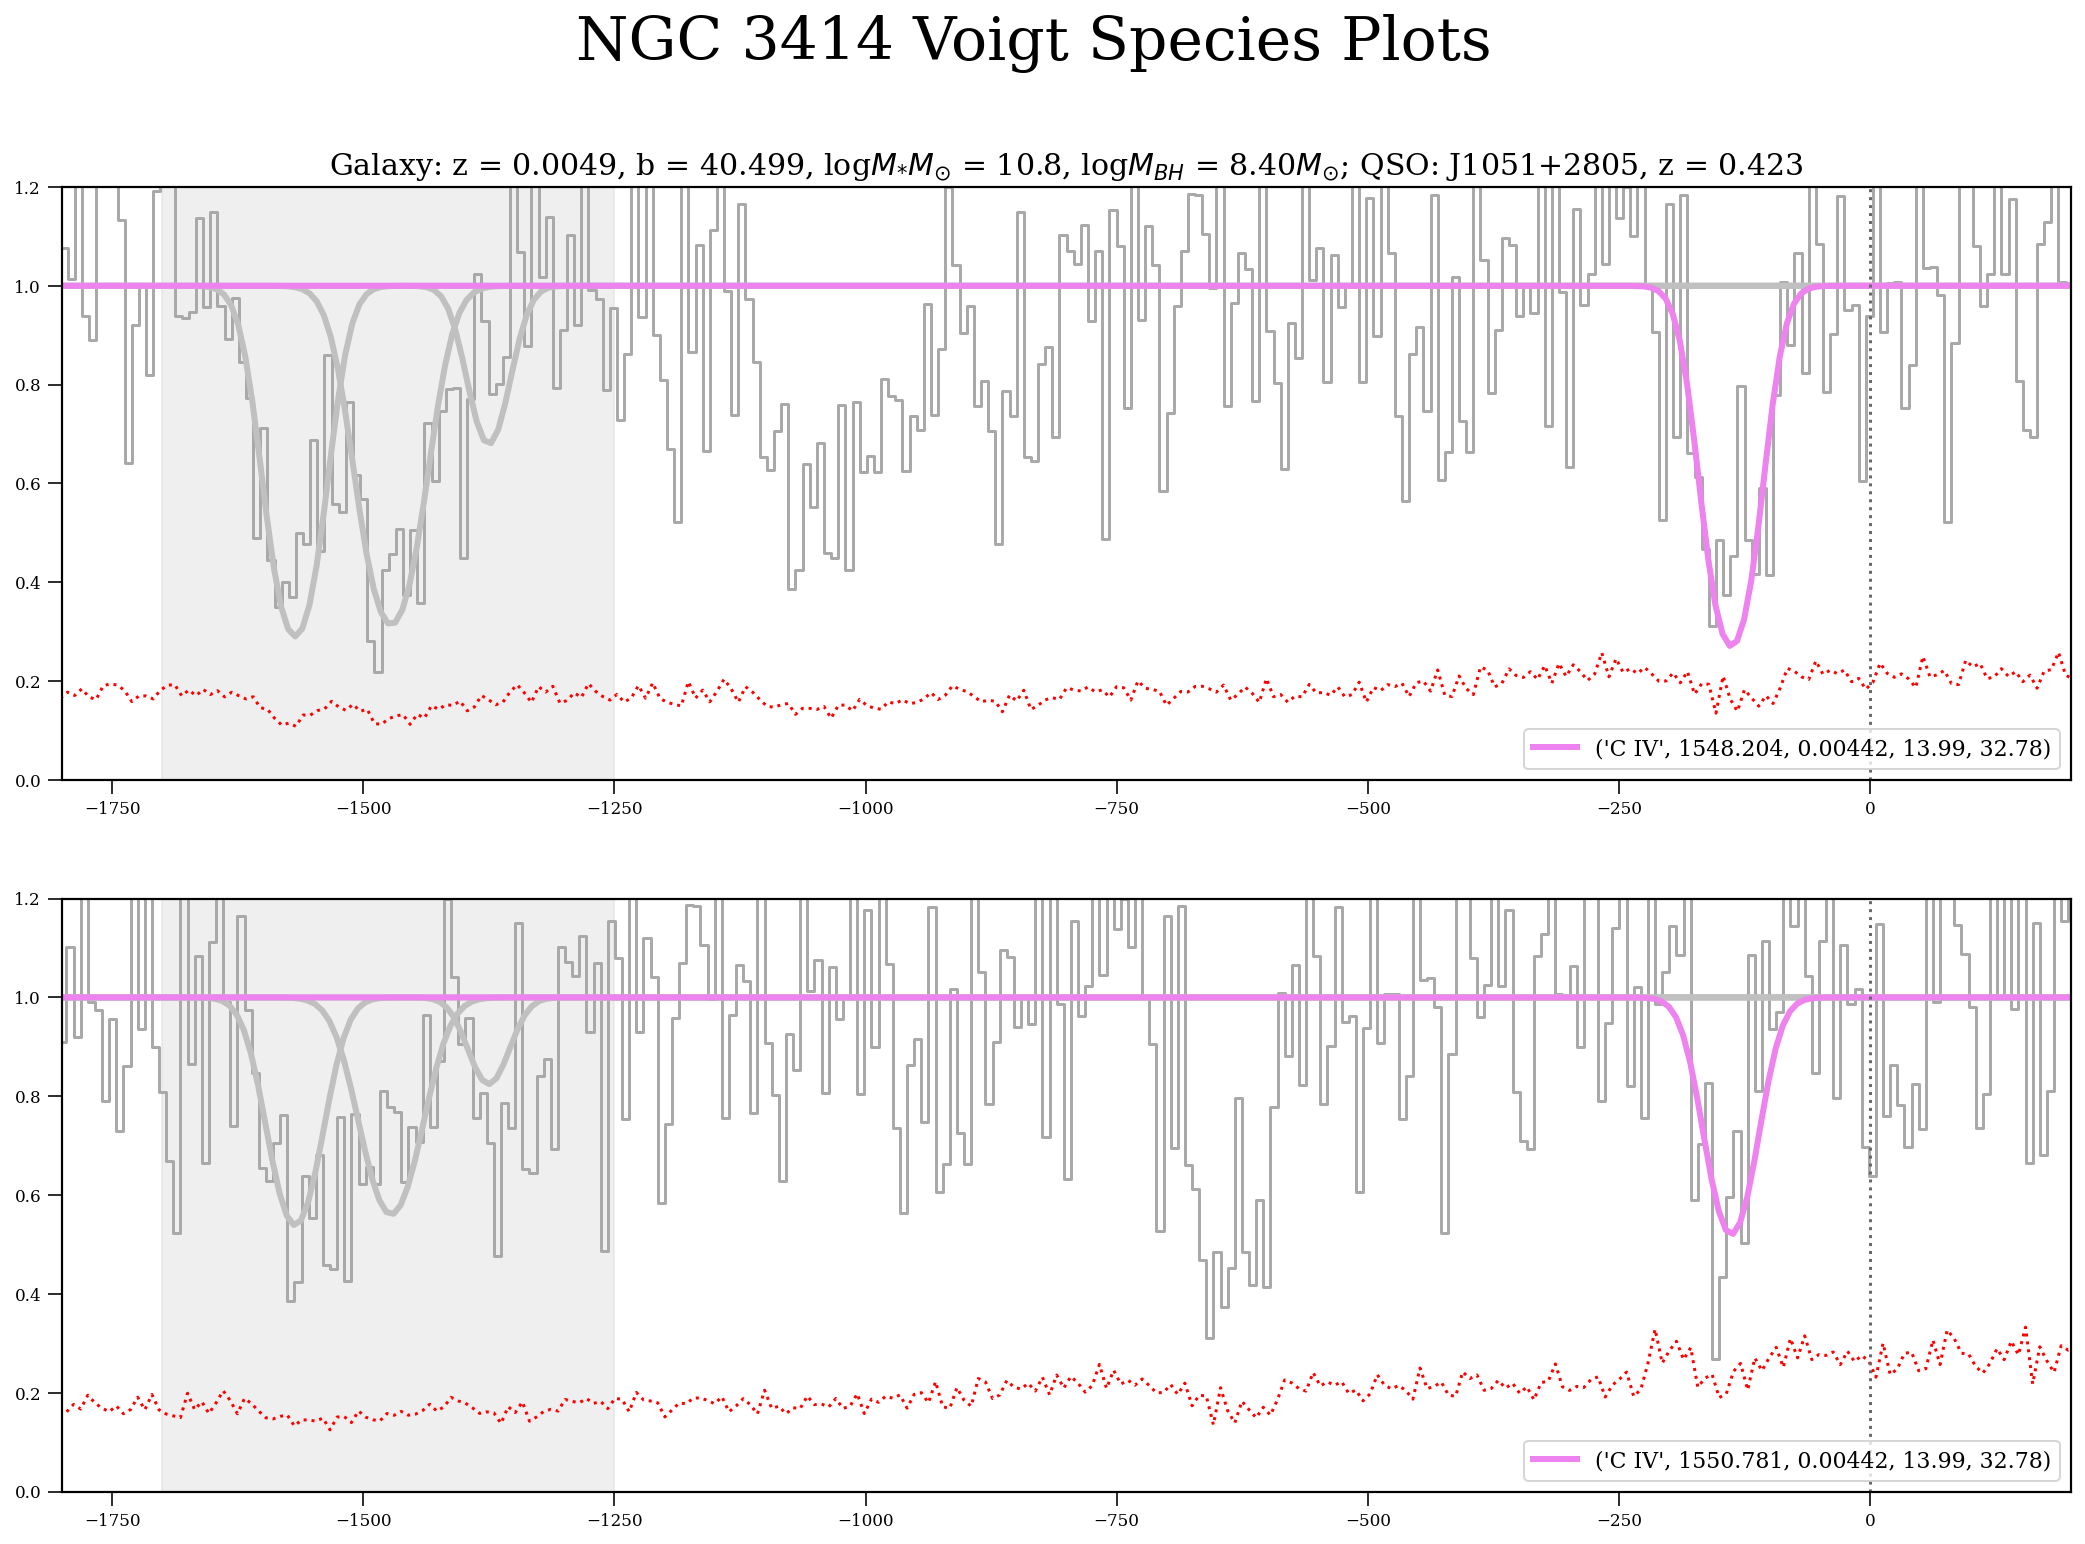

In [59]:
J1051_vsp()

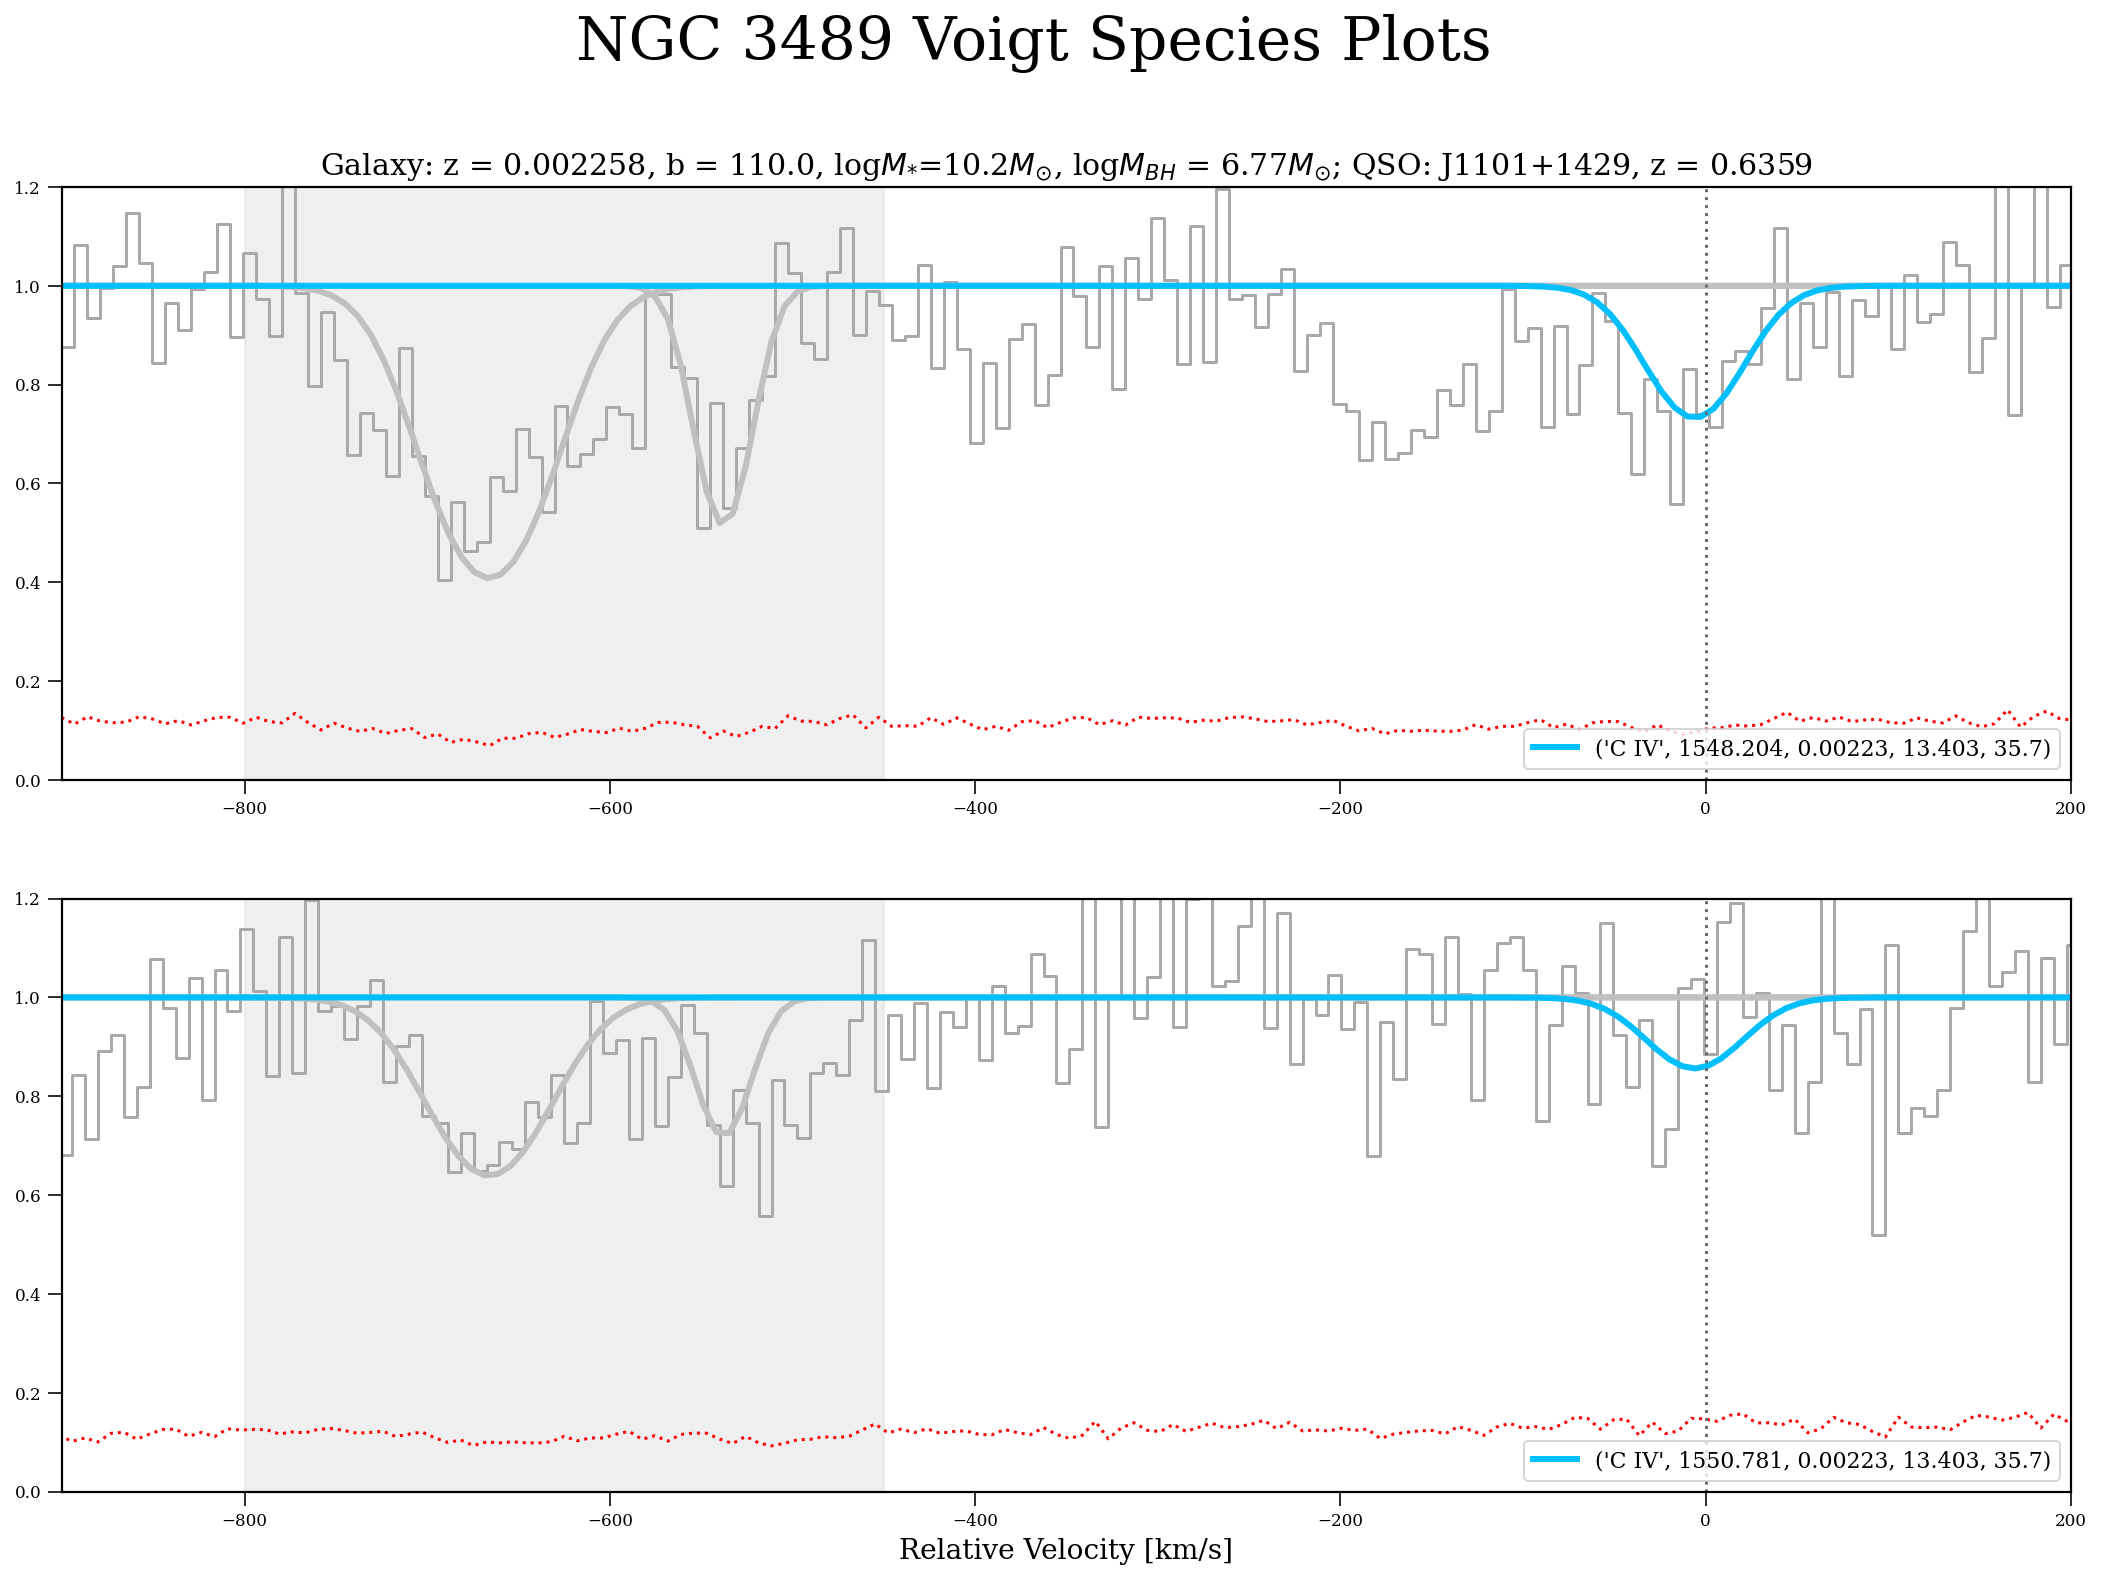

In [60]:
J1101_vsp() #it looks fine after checking pyigm 

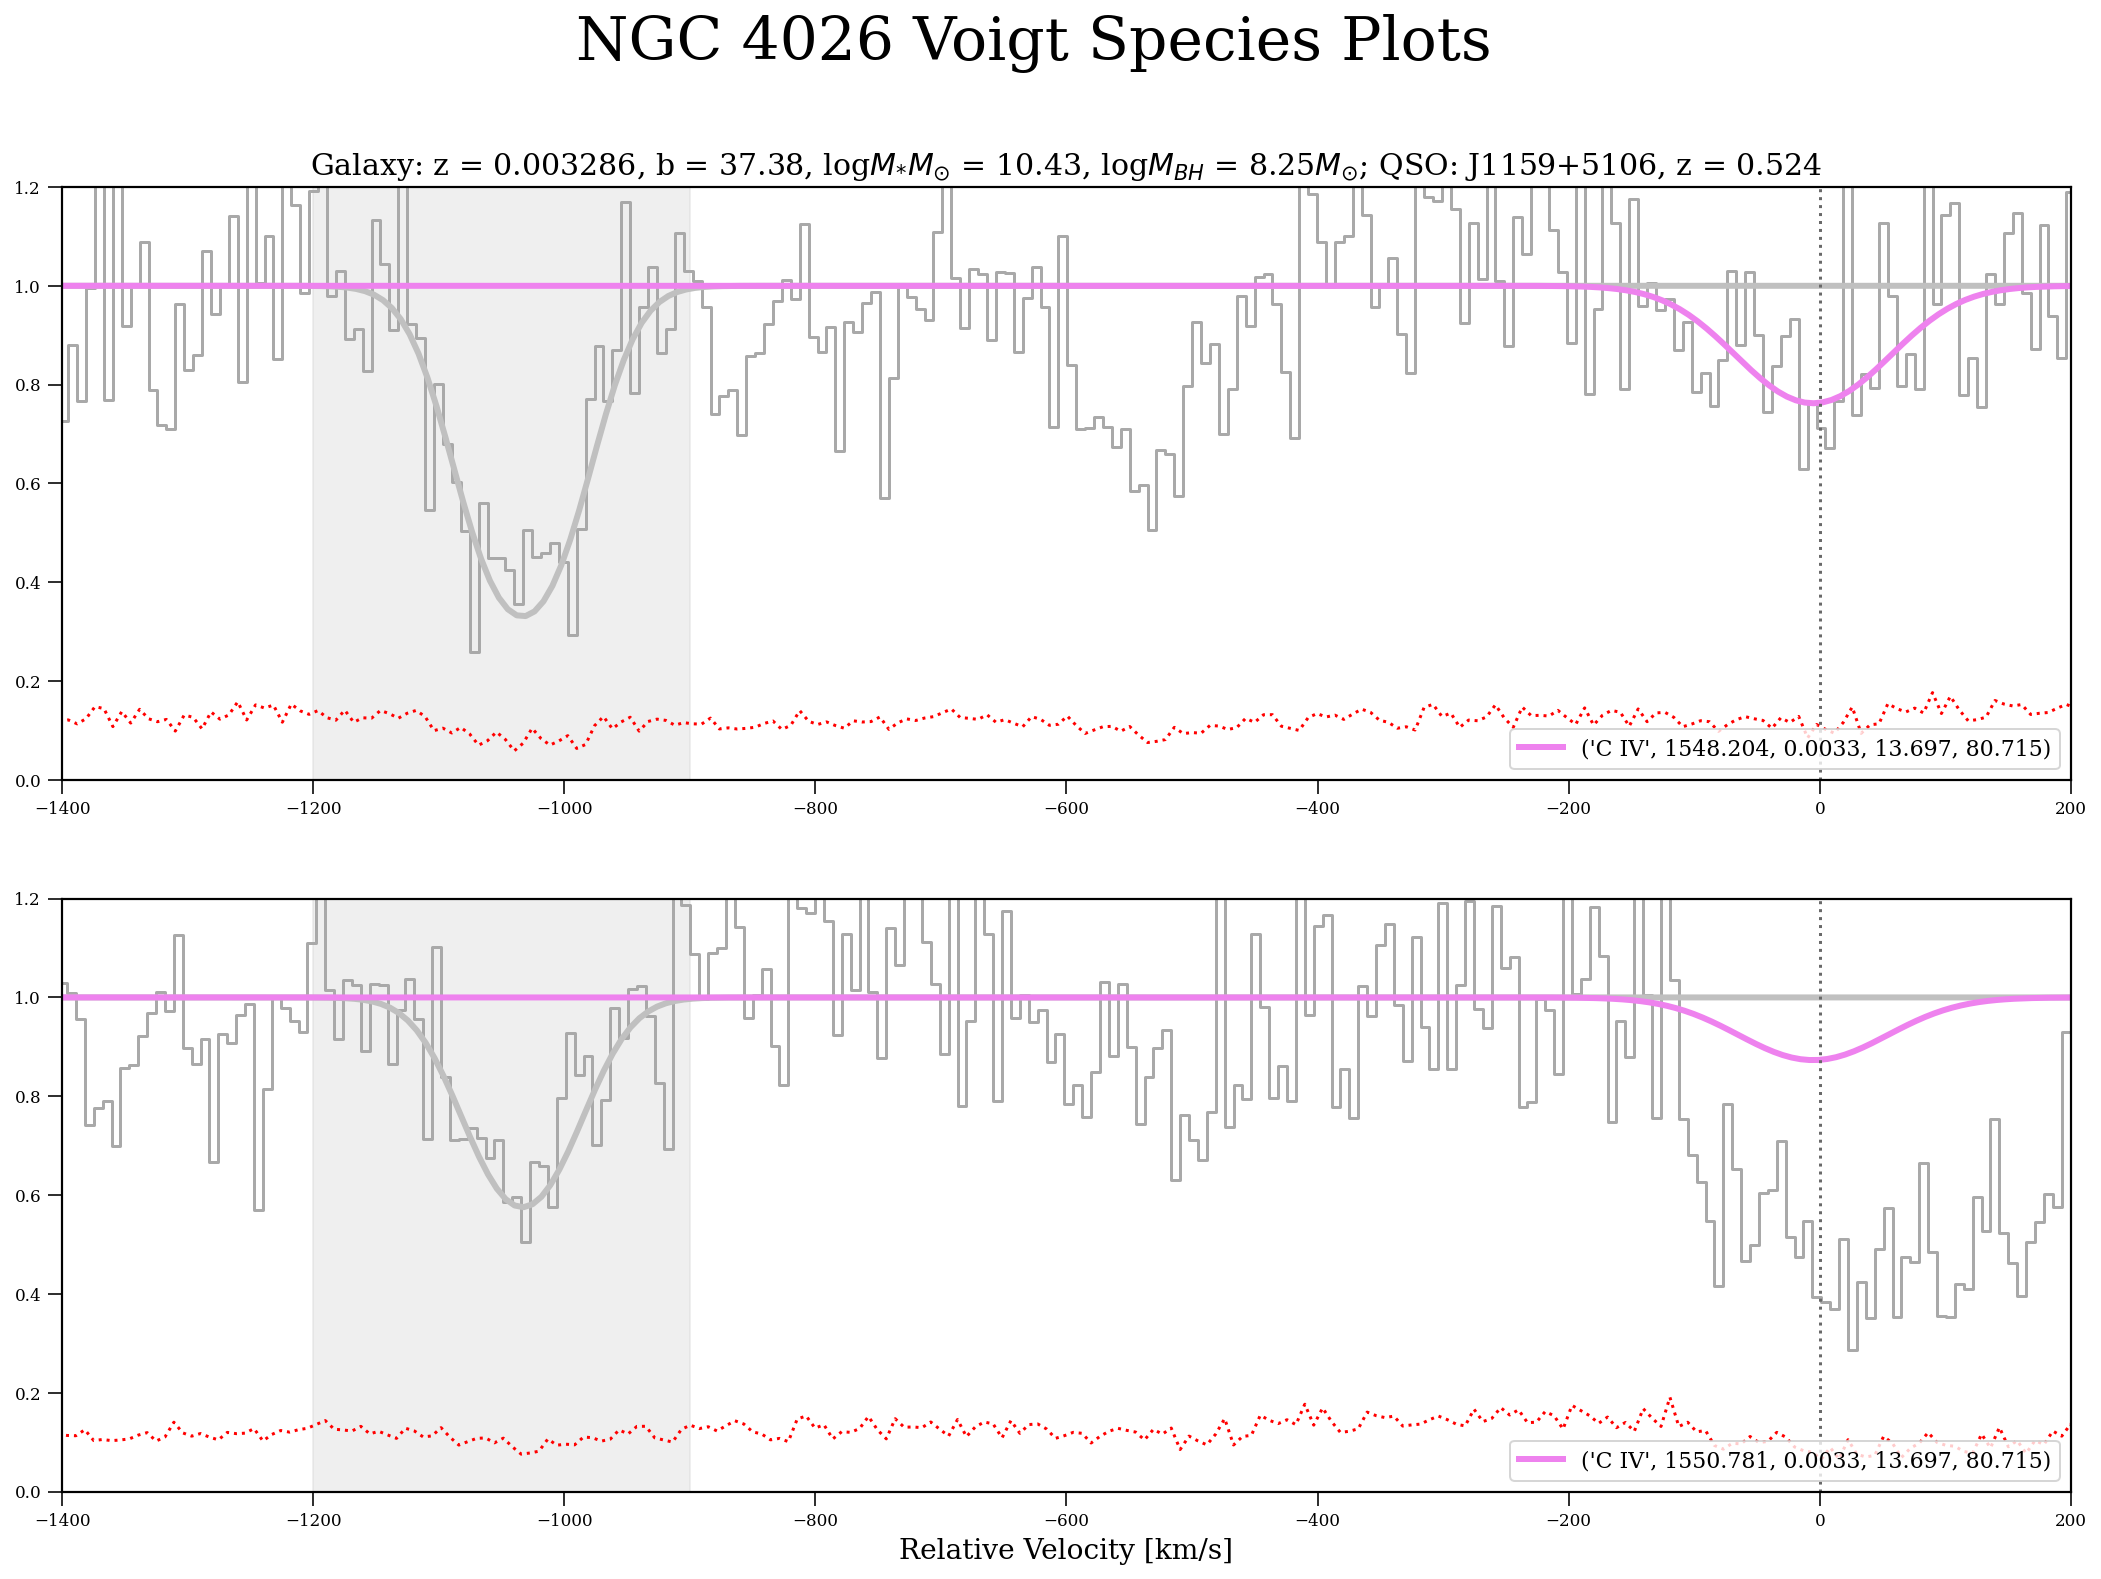

In [61]:
J1159_vsp() #Looks much better, don't know why HI is not running through the fit 

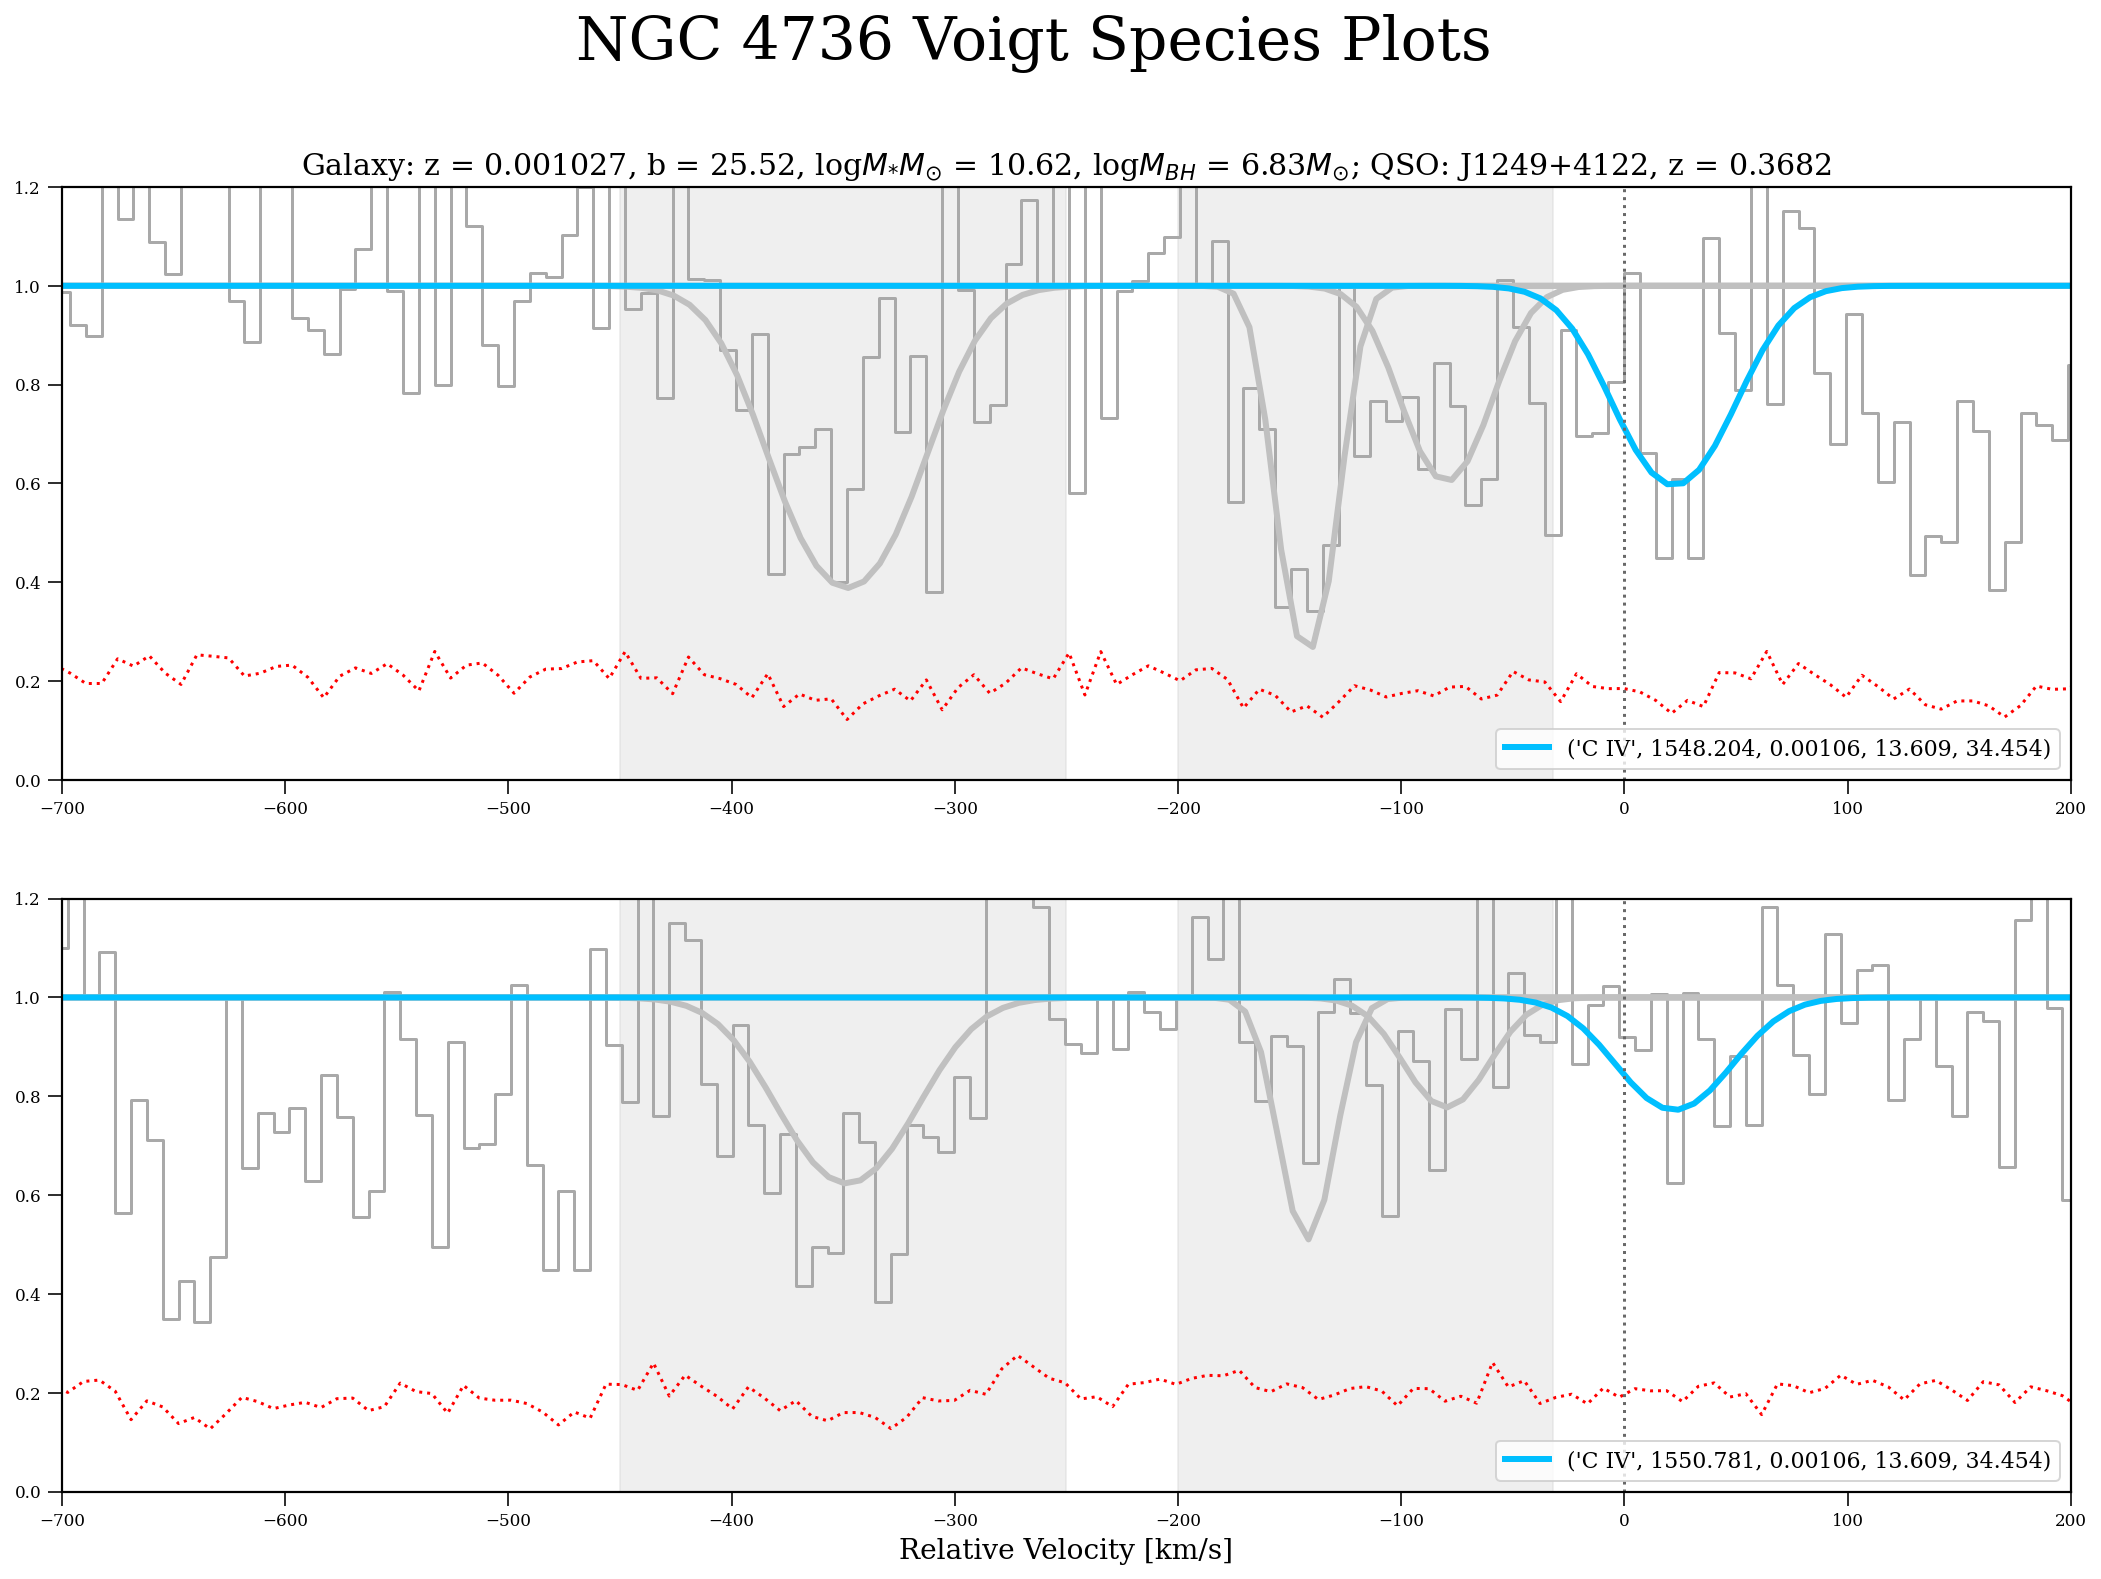

In [83]:
J1249_vsp() 

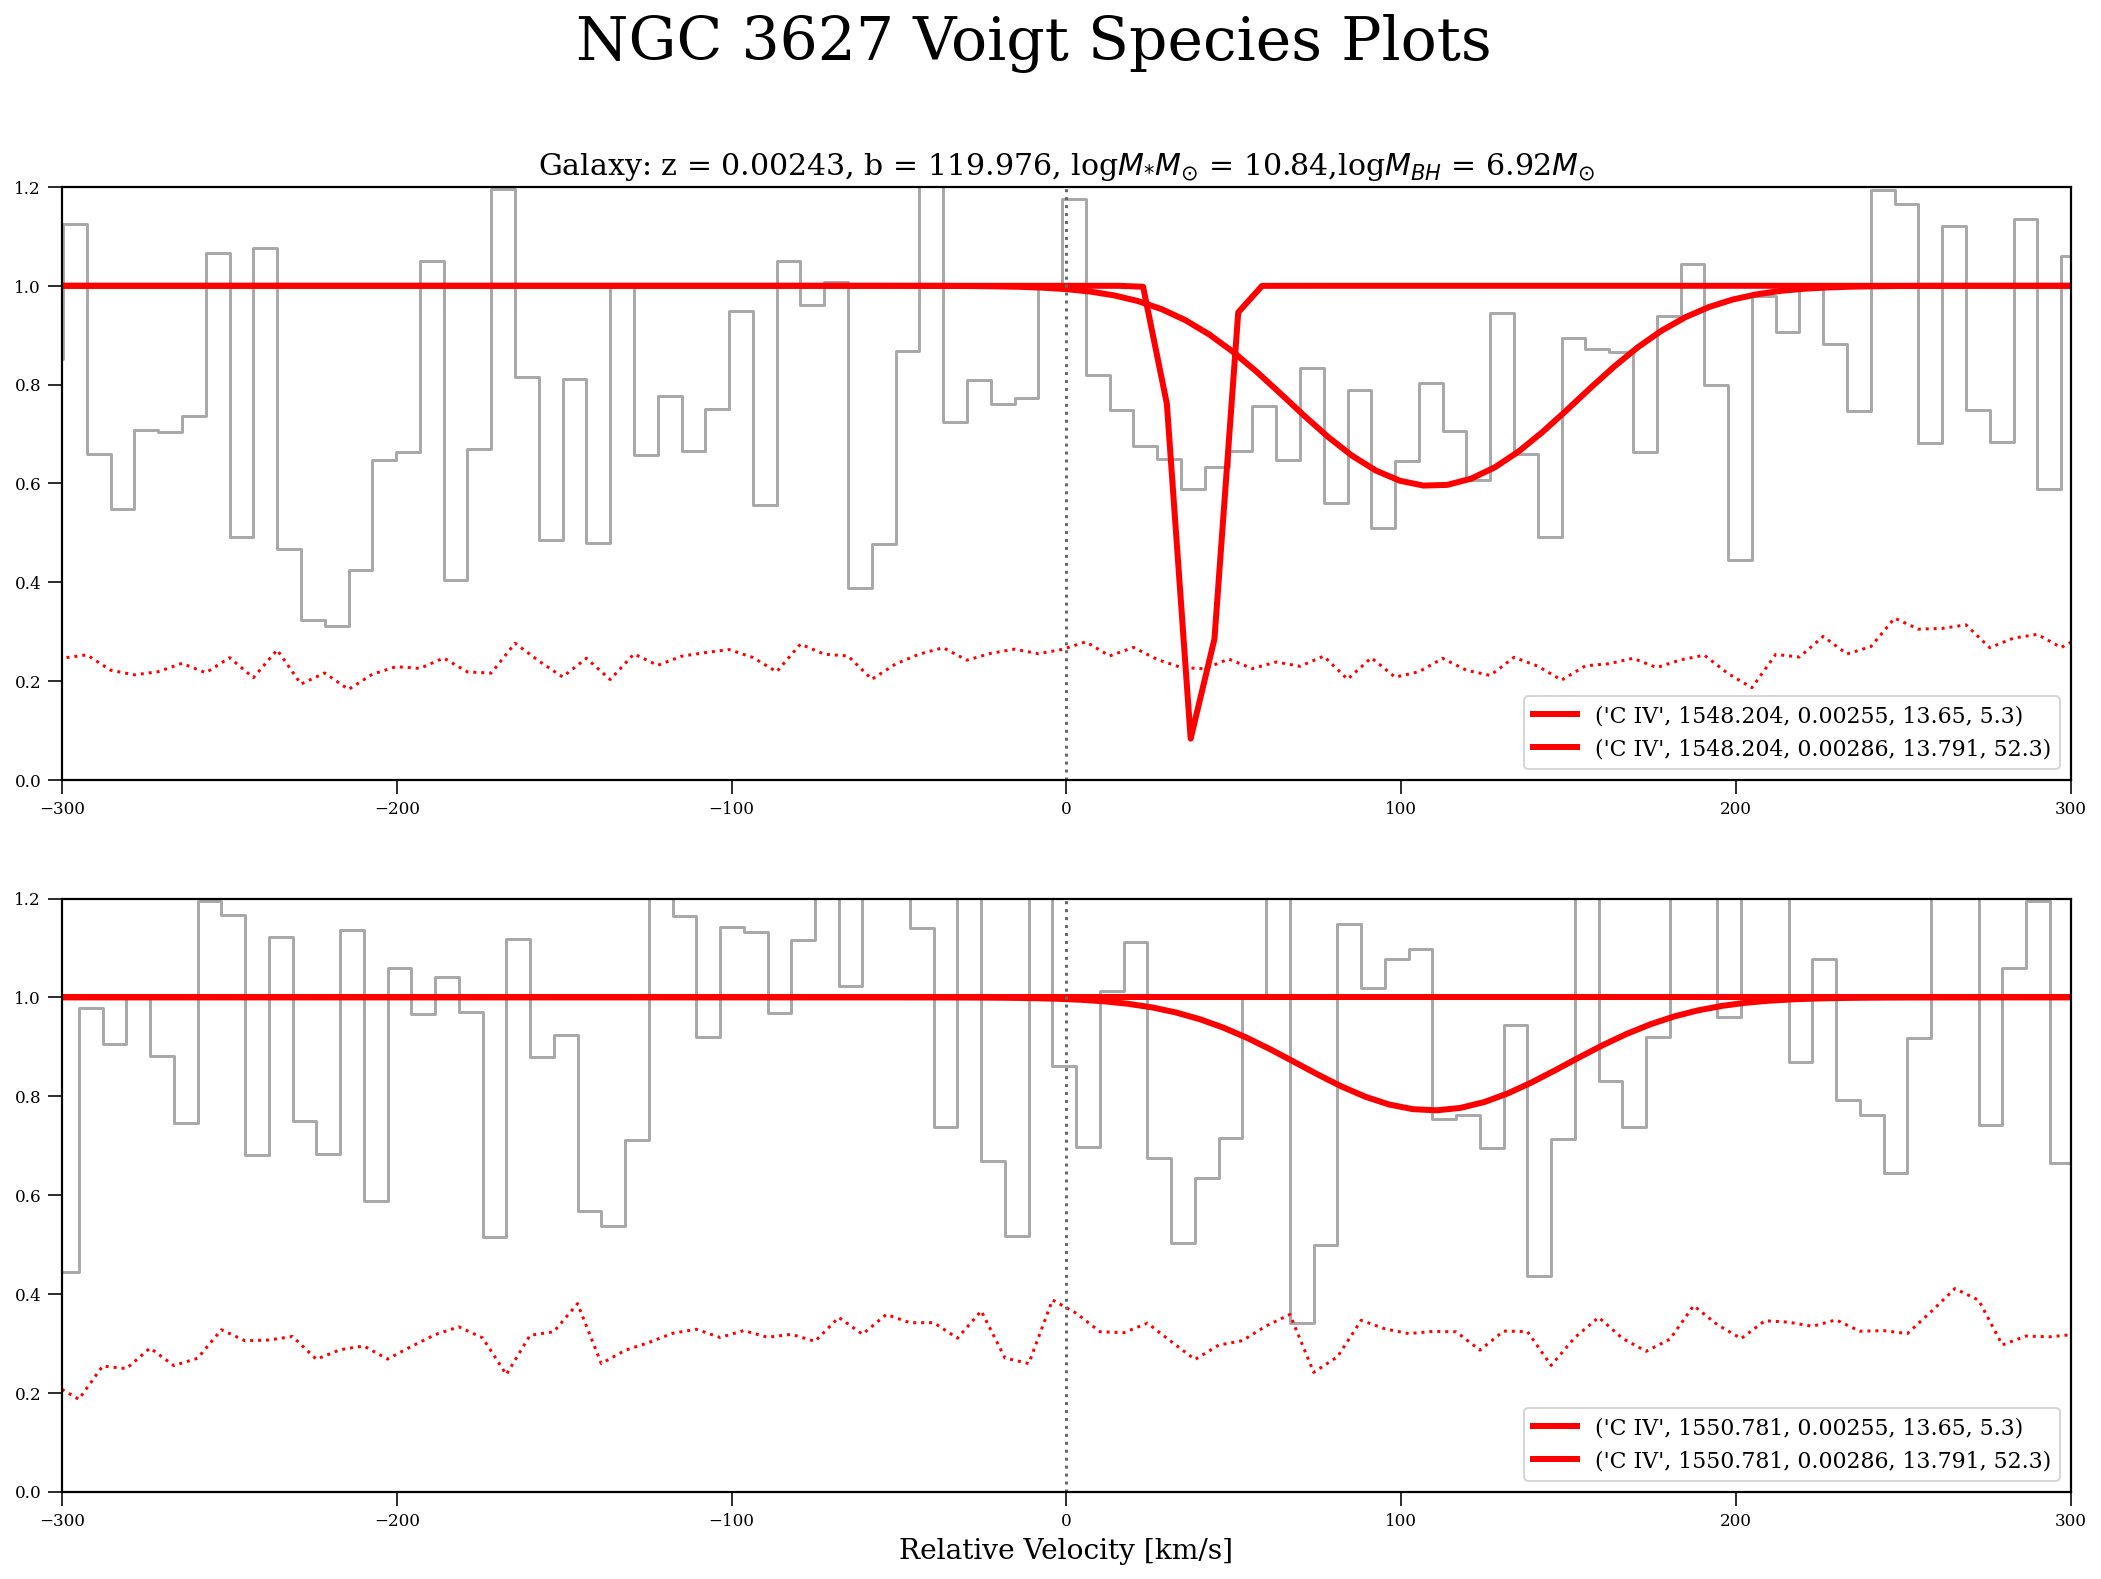

In [102]:
J1123_vsp() #ugh this does not look like the fit that I want at all , need to go back and make some changes in pyigm 

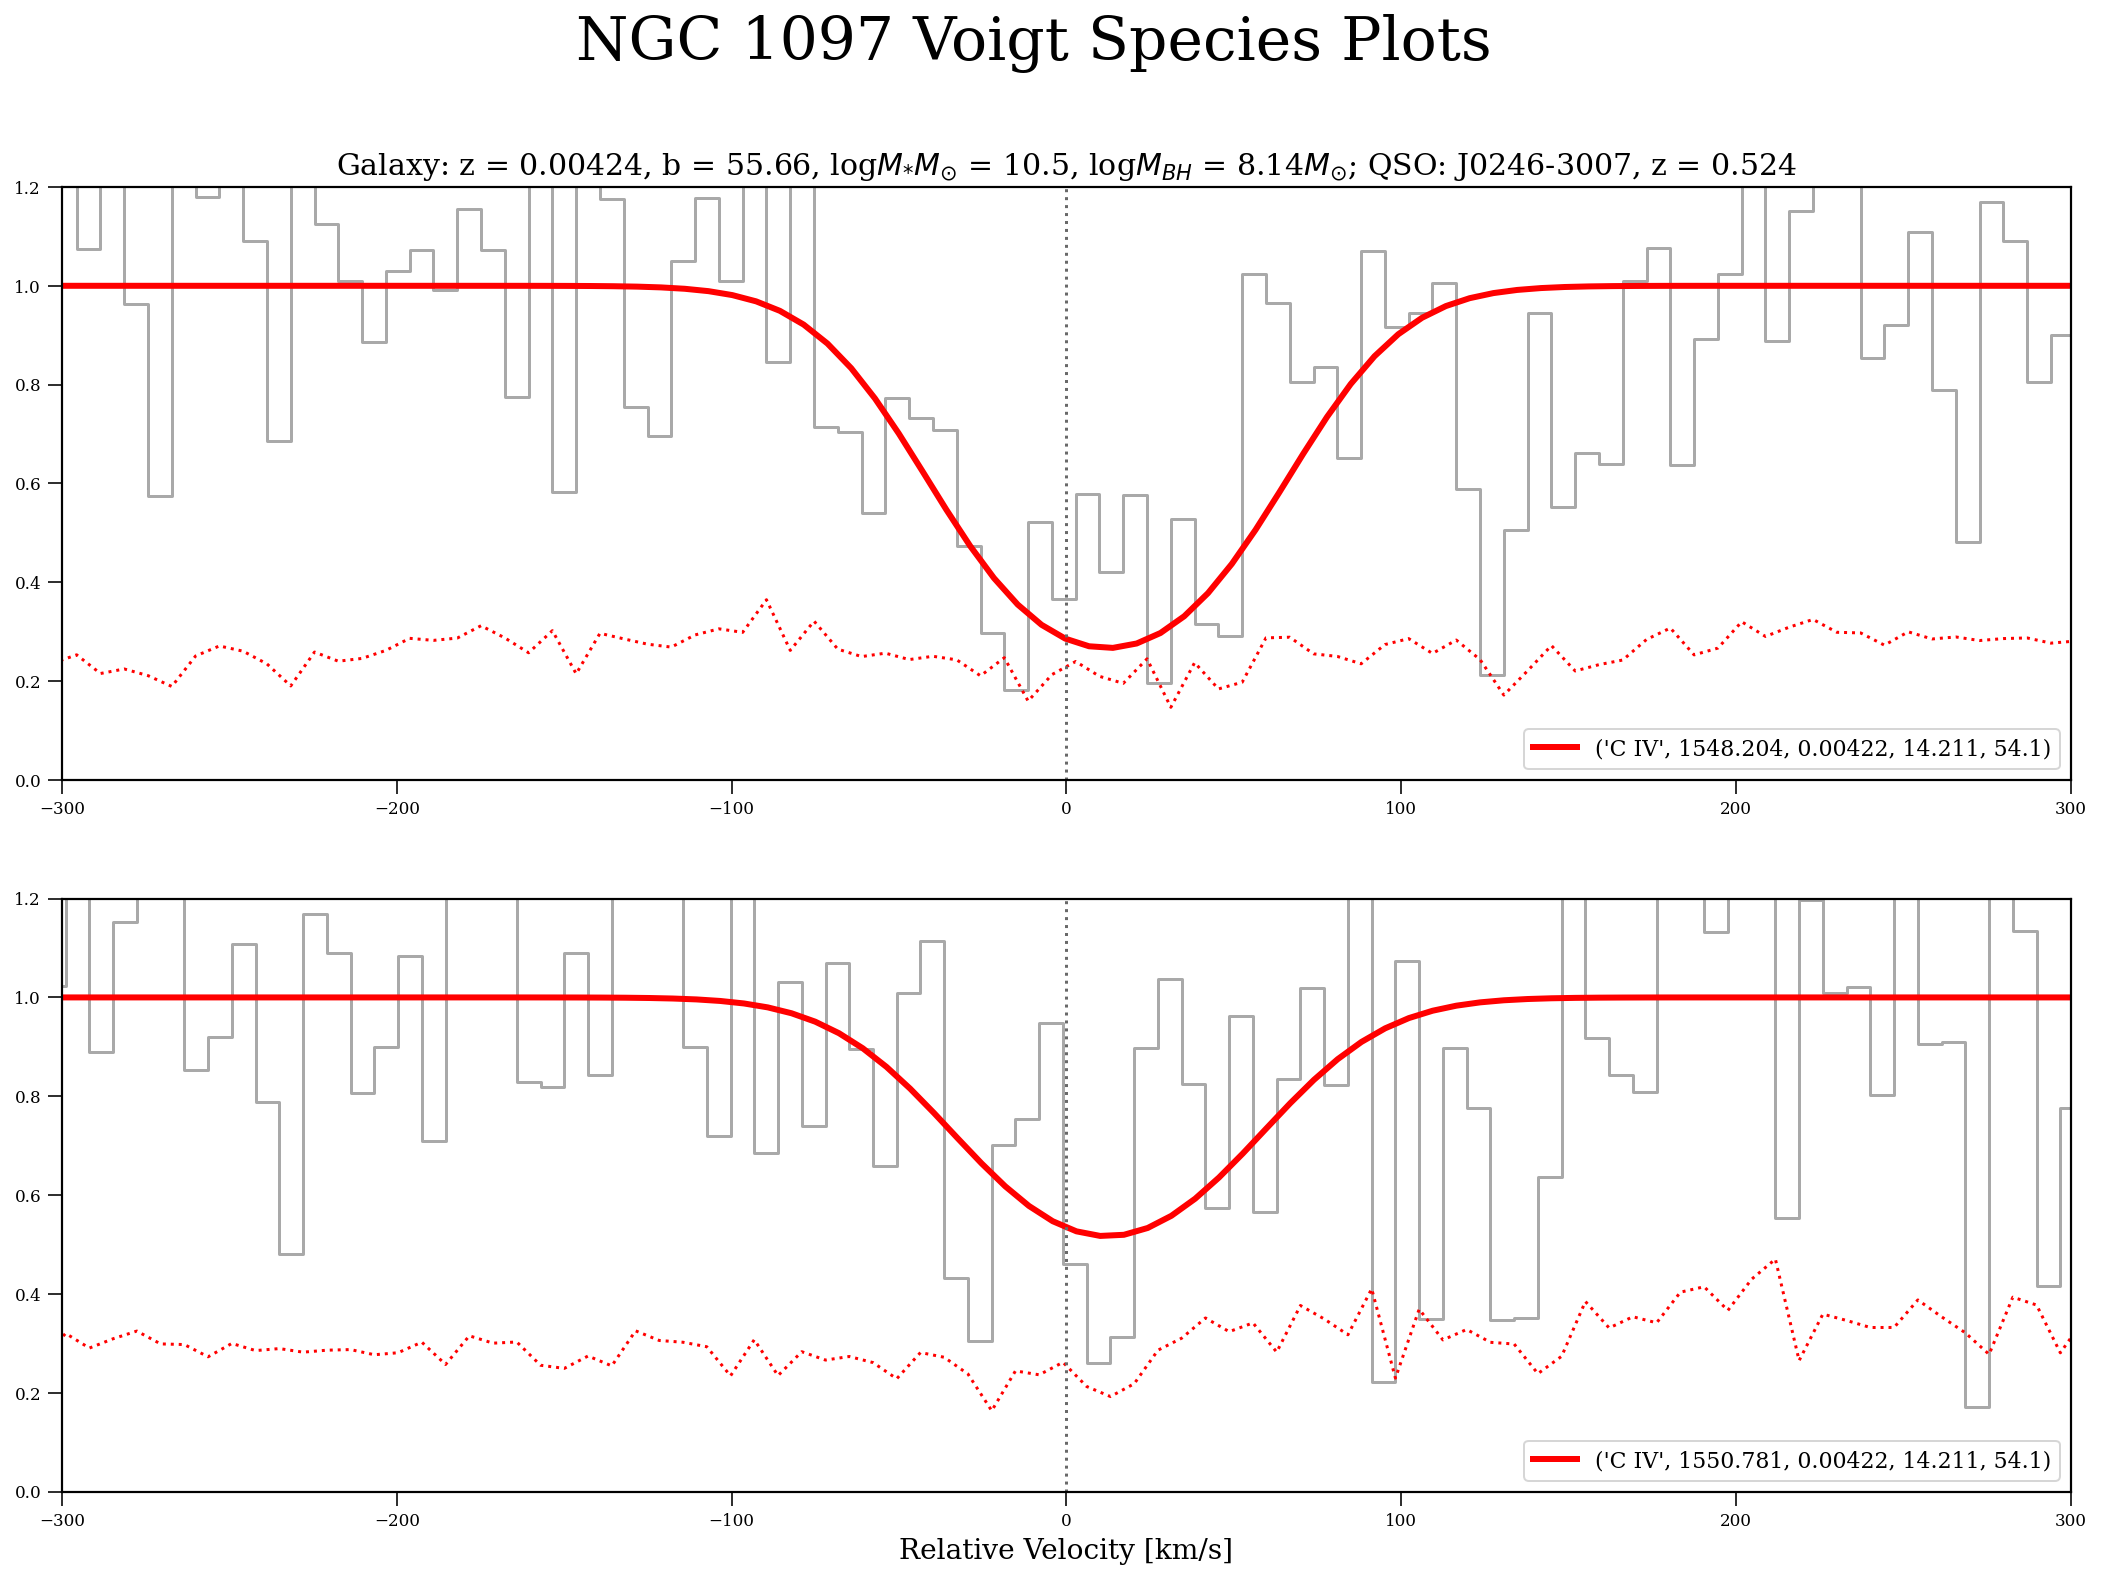

In [113]:
J0246_vsp()

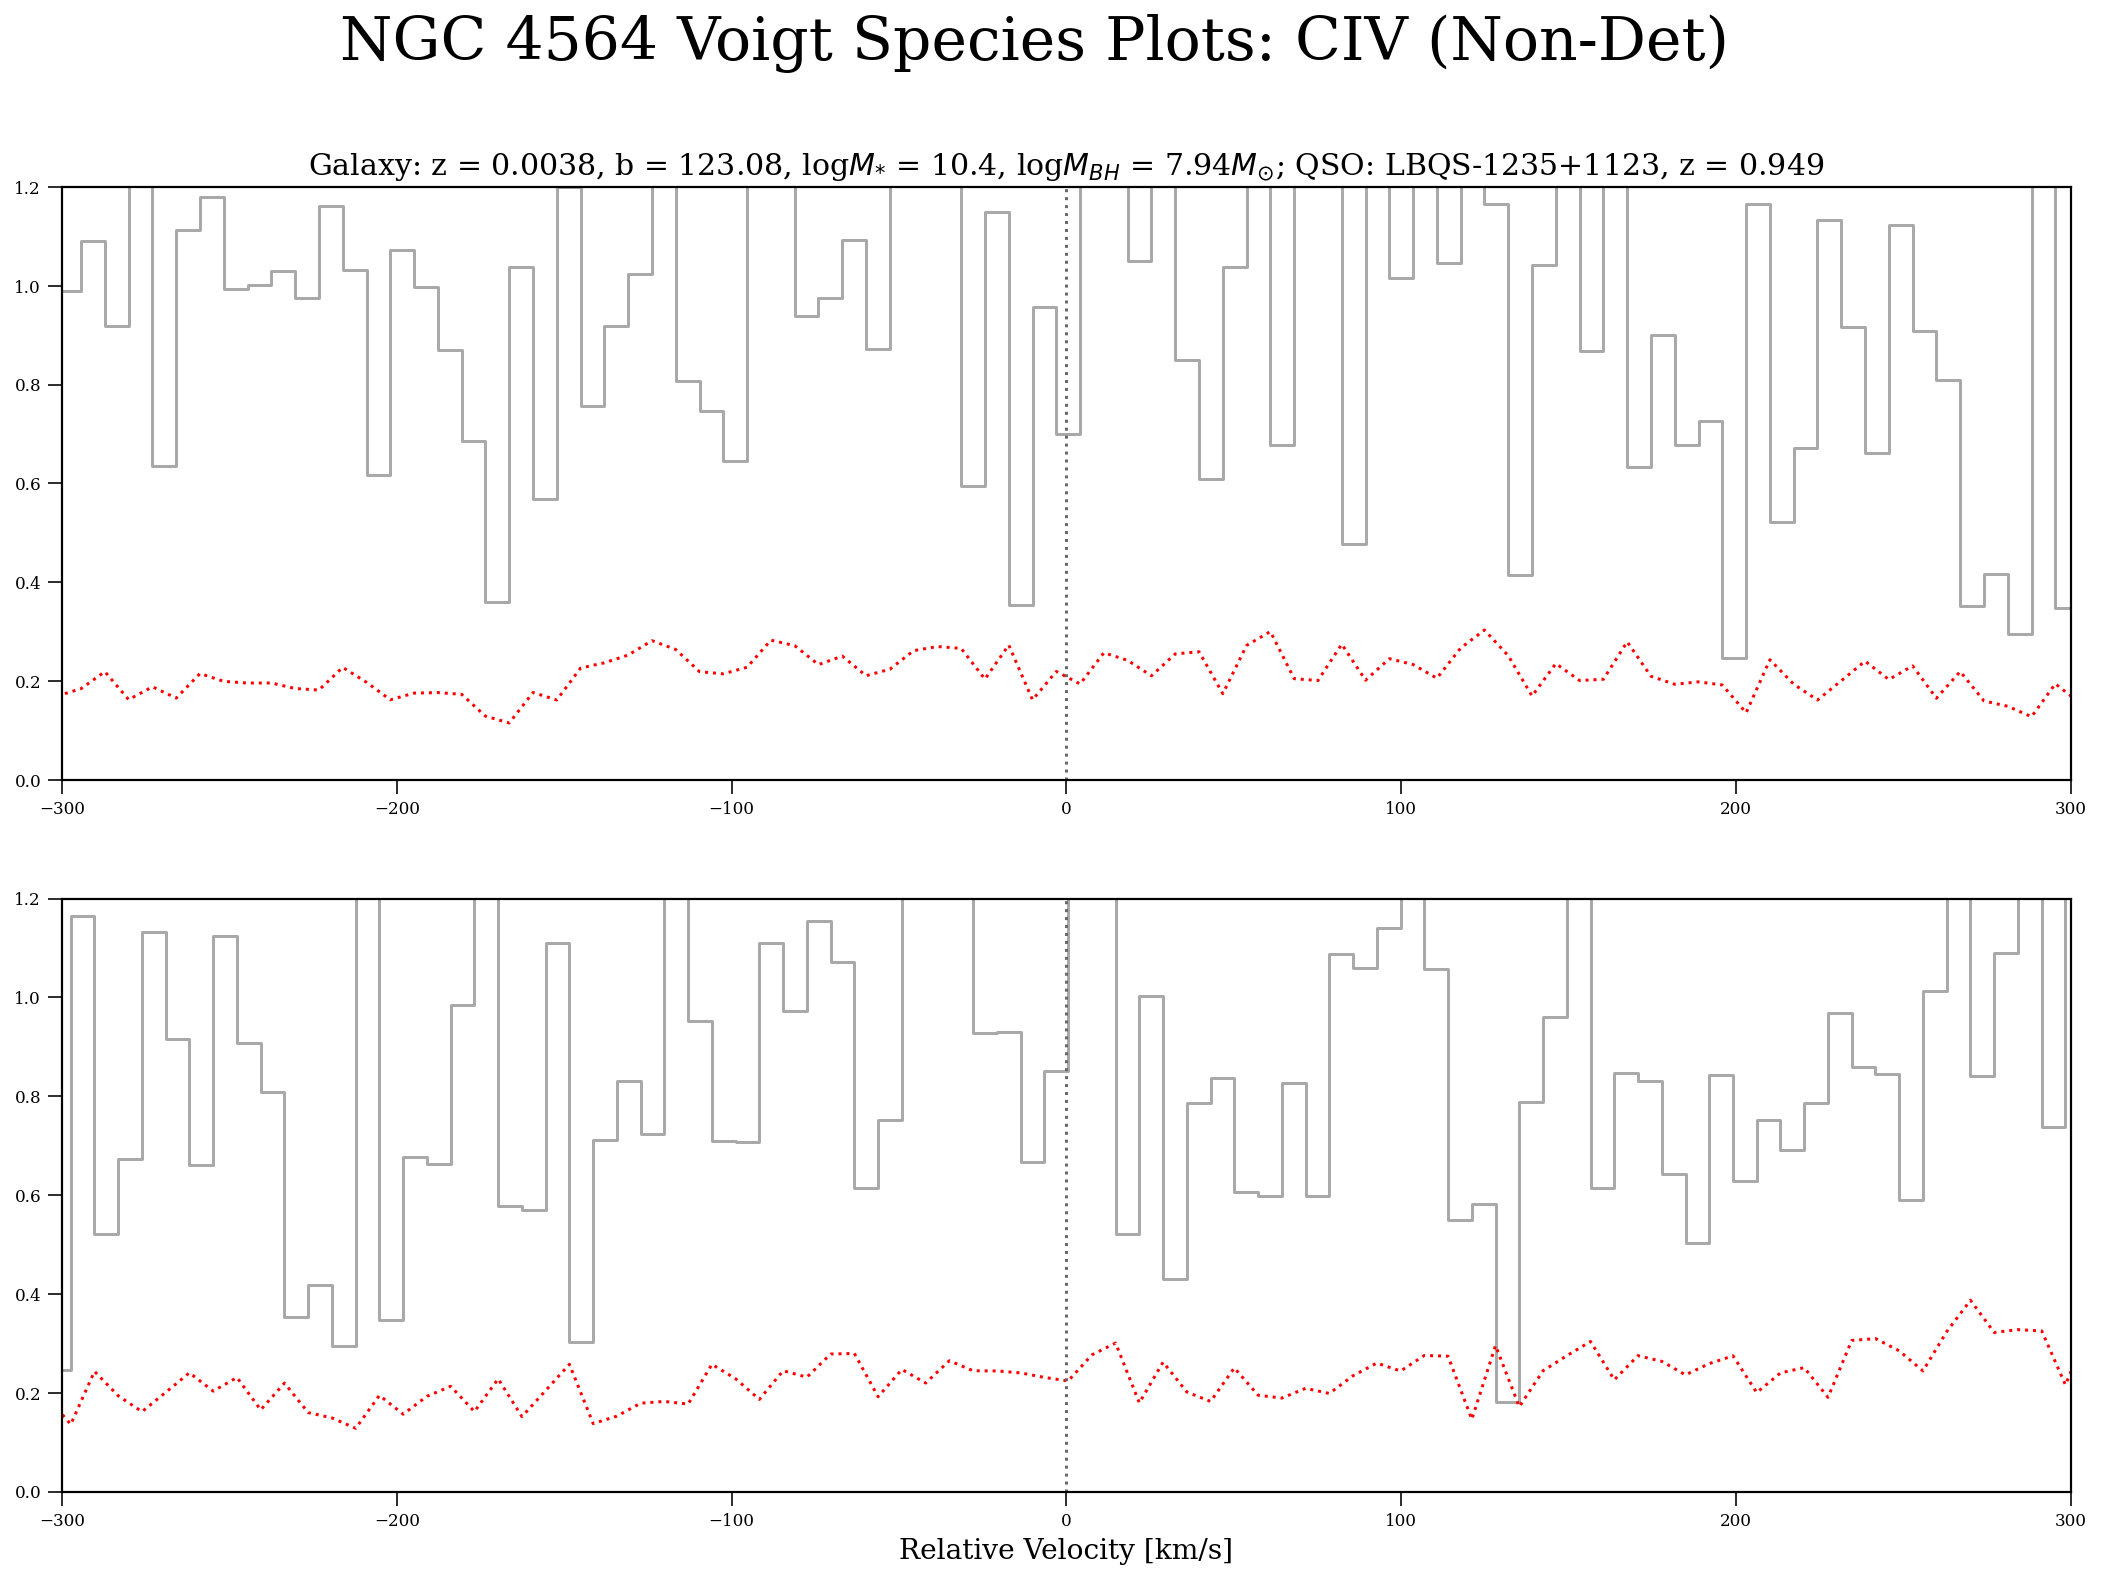

In [132]:
J1235_vsp()